# Predicting King County house prices using ML

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split



### Import and Explore Data

In [2]:
kc_preprocess = pd.read_csv('data/kc_house_data.csv')
print (kc_preprocess.info())
print ('\nis null: \n' ,kc_preprocess.isnull().sum())
kc_preprocess.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0         NaN   0.0  ...      7        1180            0.0   
1      7242     2.0         0.0   0.0  ...      7        2170          400.0   
2     10000     1.0         0.0   0.0  ...      6         770            0.0   
3      5000     1.0         0.0   0.0  ...      7        1050          910.0   
4      8080     1.0         0.0   0.0  ...      8        1680            0.0   

  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0     1955           0.0    98178  47.5112 -122.257           1340        5650  
1     1951        1991.0    98125  47.7210 -122.319           1690        7639  
2     1933           NaN    98028  47.7379 -122.233           2720        8062  
3     1965           0.0    98136  47.5208 -122.393           1360        5000  
4     1987           0.0    98074  47.6168 -122.045           1800        7503  

[5 rows x 21 columns]

### Cleaning the data

In [3]:
'''
CLEANING DATA - FILLING NAs:
In columns 'waterfront', 'view' and 'yr_renovated', we assume nulls as 0
'''
kc_preprocess[['waterfront', 'view', 'yr_renovated']] = kc_preprocess[['waterfront', 'view', 'yr_renovated']].fillna(0)
kc_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  float64
 9   view           21597 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
'''
CHECK FOR PLACEHOLDERS
From data info, we can see that Dtype of 'sqft_basement' is object.
Hence, there is a high chance the column contains placeholders.
We can find placeholders using value_count()
'''


(kc_preprocess['sqft_basement'].value_counts())


sqft_basement
0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1920.0        1
3480.0        1
2730.0        1
2720.0        1
248.0         1
Name: count, Length: 304, dtype: int64

In [5]:
'''
REPLACE PLACEHOLDER '?' with 0.0 in column 'sqft_basement'
'''
kc_preprocess['sqft_basement'] = kc_preprocess['sqft_basement'].str.replace('?','0.0', regex = False)

(kc_preprocess['sqft_basement'].value_counts())

sqft_basement
0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
1920.0        1
3480.0        1
2730.0        1
2720.0        1
248.0         1
Name: count, Length: 303, dtype: int64

In [6]:
kc_preprocess['sqft_basement'] = pd.to_numeric(kc_preprocess['sqft_basement'])
kc_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  float64
 9   view           21597 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  float64
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [7]:
'''
CLEANING DATA - CHECK FOR DUPLICATES
'''
kc_preprocess.duplicated(subset = ['id', 'price']).value_counts()
print('Duplicates: ', kc_preprocess.duplicated(subset = ['id', 'price']).sum())
kc_preprocess.loc[kc_preprocess.duplicated(subset = ['id', 'price'], keep=False), :]
kc_preprocess.drop_duplicates(subset = ['id', 'price'])

Duplicates:  3


id        date     price  bedrooms  bathrooms  sqft_living  \
0      7129300520  10/13/2014  221900.0         3       1.00         1180   
1      6414100192   12/9/2014  538000.0         3       2.25         2570   
2      5631500400   2/25/2015  180000.0         2       1.00          770   
3      2487200875   12/9/2014  604000.0         4       3.00         1960   
4      1954400510   2/18/2015  510000.0         3       2.00         1680   
...           ...         ...       ...       ...        ...          ...   
21592   263000018   5/21/2014  360000.0         3       2.50         1530   
21593  6600060120   2/23/2015  400000.0         4       2.50         2310   
21594  1523300141   6/23/2014  402101.0         2       0.75         1020   
21595   291310100   1/16/2015  400000.0         3       2.50         1600   
21596  1523300157  10/15/2014  325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
0          5650     1.0         0.0   0.0  ...      7        1180   
1          7242     2.0         0.0   0.0  ...      7        2170   
2         10000     1.0         0.0   0.0  ...      6         770   
3          5000     1.0         0.0   0.0  ...      7        1050   
4          8080     1.0         0.0   0.0  ...      8        1680   
...         ...     ...         ...   ...  ...    ...         ...   
21592      1131     3.0         0.0   0.0  ...      8        1530   
21593      5813     2.0         0.0   0.0  ...      8        2310   
21594      1350     2.0         0.0   0.0  ...      7        1020   
21595      2388     2.0         0.0   0.0  ...      8        1600   
21596      1076     2.0         0.0   0.0  ...      7        1020   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0                0.0      1955           0.0    98178  47.5112 -122.257   
1              400.0      1951        1991.0    98125  47.7210 -122.319   
2                0.0      1933           0.0    98028  47.7379 -122.233   
3              910.0      1965           0.0    98136  47.5208 -122.393   
4                0.0      1987           0.0    98074  47.6168 -122.045   
...              ...       ...           ...      ...      ...      ...   
21592            0.0      2009           0.0    98103  47.6993 -122.346   
21593            0.0      2014           0.0    98146  47.5107 -122.362   
21594            0.0      2009           0.0    98144  47.5944 -122.299   
21595            0.0      2004           0.0    98027  47.5345 -122.069   
21596            0.0      2008           0.0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  
0               1340        5650  
1               1690        7639  
2               2720        8062  
3               1360        5000  
4               1800        7503  
...              ...         ...  
21592           1530        1509  
21593           1830        7200  
21594           1020        2007  
21595           1410        1287  
21596           1020        1357  

[21594 rows x 21 columns]

In [8]:
kc_preprocess['yr_renovated'] = kc_preprocess['yr_renovated'] > 0 #converting to boolean 
kc_preprocess['yr_renovated'] = kc_preprocess['yr_renovated'].astype('int') #changing to binary format
kc_preprocess = kc_preprocess.rename(columns = {'yr_renovated':'renovated'})
kc_preprocess['renovated']

0        0
1        1
2        0
3        0
4        0
        ..
21592    0
21593    0
21594    0
21595    0
21596    0
Name: renovated, Length: 21597, dtype: int32

In [9]:
kc_preprocess

id        date     price  bedrooms  bathrooms  sqft_living  \
0      7129300520  10/13/2014  221900.0         3       1.00         1180   
1      6414100192   12/9/2014  538000.0         3       2.25         2570   
2      5631500400   2/25/2015  180000.0         2       1.00          770   
3      2487200875   12/9/2014  604000.0         4       3.00         1960   
4      1954400510   2/18/2015  510000.0         3       2.00         1680   
...           ...         ...       ...       ...        ...          ...   
21592   263000018   5/21/2014  360000.0         3       2.50         1530   
21593  6600060120   2/23/2015  400000.0         4       2.50         2310   
21594  1523300141   6/23/2014  402101.0         2       0.75         1020   
21595   291310100   1/16/2015  400000.0         3       2.50         1600   
21596  1523300157  10/15/2014  325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
0          5650     1.0         0.0   0.0  ...      7        1180   
1          7242     2.0         0.0   0.0  ...      7        2170   
2         10000     1.0         0.0   0.0  ...      6         770   
3          5000     1.0         0.0   0.0  ...      7        1050   
4          8080     1.0         0.0   0.0  ...      8        1680   
...         ...     ...         ...   ...  ...    ...         ...   
21592      1131     3.0         0.0   0.0  ...      8        1530   
21593      5813     2.0         0.0   0.0  ...      8        2310   
21594      1350     2.0         0.0   0.0  ...      7        1020   
21595      2388     2.0         0.0   0.0  ...      8        1600   
21596      1076     2.0         0.0   0.0  ...      7        1020   

       sqft_basement  yr_built  renovated  zipcode      lat     long  \
0                0.0      1955          0    98178  47.5112 -122.257   
1              400.0      1951          1    98125  47.7210 -122.319   
2                0.0      1933          0    98028  47.7379 -122.233   
3              910.0      1965          0    98136  47.5208 -122.393   
4                0.0      1987          0    98074  47.6168 -122.045   
...              ...       ...        ...      ...      ...      ...   
21592            0.0      2009          0    98103  47.6993 -122.346   
21593            0.0      2014          0    98146  47.5107 -122.362   
21594            0.0      2009          0    98144  47.5944 -122.299   
21595            0.0      2004          0    98027  47.5345 -122.069   
21596            0.0      2008          0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  
0               1340        5650  
1               1690        7639  
2               2720        8062  
3               1360        5000  
4               1800        7503  
...              ...         ...  
21592           1530        1509  
21593           1830        7200  
21594           1020        2007  
21595           1410        1287  
21596           1020        1357  

[21597 rows x 21 columns]

In [10]:
'''
CLEANING DATA - REMOVE DUPLICATES
'''
kc_preprocess = kc_preprocess.drop_duplicates(subset = ['id', 'price'], keep = 'last') 
print('Duplicates: ', kc_preprocess.duplicated(subset = ['id', 'price']).sum())

Duplicates:  0


In [11]:
'''
CLEANING DATA - REMOVING UNUSED COLUMNS
We remove columns that have little to no effect on the dependant variable
'''

kc_preprocess = kc_preprocess.drop(columns = ['id', 'yr_built', 'date', 'lat', 'long', 'zipcode'], axis = 1)
kc_preprocess.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'renovated', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [12]:
'''
Check for outliers
'''

kc_preprocess.describe()

price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.159400e+04  21594.000000  21594.000000  21594.000000  2.159400e+04   
mean   5.402934e+05      3.373206      2.115808   2080.303371  1.510073e+04   
std    3.673935e+05      0.926346      0.769025    918.165554  4.141535e+04   
min    7.800000e+04      1.000000      0.500000    370.000000  5.200000e+02   
25%    3.220000e+05      3.000000      1.750000   1430.000000  5.040000e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.619000e+03   
75%    6.450000e+05      4.000000      2.500000   2550.000000  1.068650e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

             floors    waterfront          view     condition         grade  \
count  21594.000000  21594.000000  21594.000000  21594.000000  21594.000000   
mean       1.494026      0.006761      0.233074      3.409836      7.657822   
std        0.539687      0.081950      0.764491      0.650566      1.173241   
min        1.000000      0.000000      0.000000      1.000000      3.000000   
25%        1.000000      0.000000      0.000000      3.000000      7.000000   
50%        1.500000      0.000000      0.000000      3.000000      7.000000   
75%        2.000000      0.000000      0.000000      4.000000      8.000000   
max        3.500000      1.000000      4.000000      5.000000     13.000000   

         sqft_above  sqft_basement     renovated  sqft_living15     sqft_lot15  
count  21594.000000   21594.000000  21594.000000   21594.000000   21594.000000  
mean    1788.554043     285.740067      0.034408    1986.586506   12758.858850  
std      827.807526     439.841568      0.182278     685.264963   27276.234148  
min      370.000000       0.000000      0.000000     399.000000     651.000000  
25%     1190.000000       0.000000      0.000000    1490.000000    5100.000000  
50%     1560.000000       0.000000      0.000000    1840.000000    7620.000000  
75%     2210.000000     550.000000      0.000000    2360.000000   10082.250000  
max     9410.000000    4820.000000      1.000000    6210.000000  871200.000000

bedrooms
3     9822
4     6881
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: count, dtype: int64


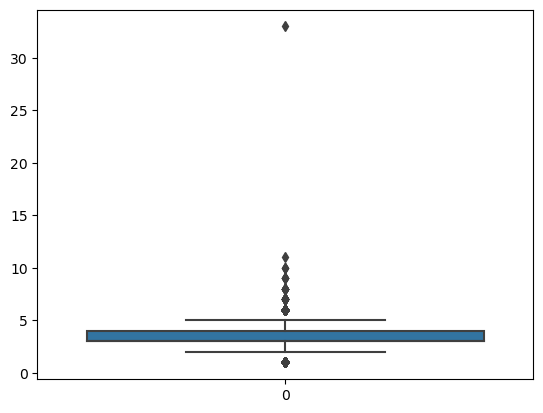

In [13]:
sns.boxplot(kc_preprocess['bedrooms'])
print(kc_preprocess['bedrooms'].value_counts())

bathrooms
2.50    5375
1.00    3851
1.75    3047
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: count, dtype: int64


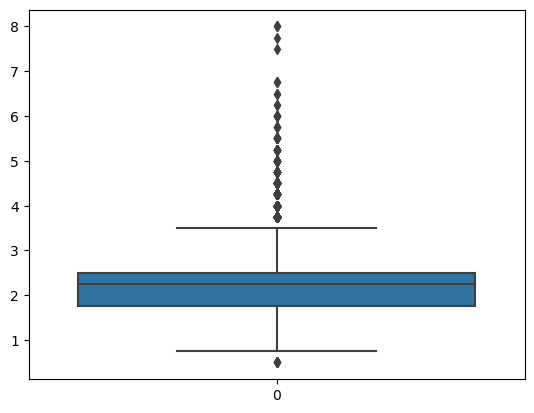

In [14]:
sns.boxplot(kc_preprocess['bathrooms'])
print(kc_preprocess['bathrooms'].value_counts())

bathrooms
2.50    5375
1.00    3851
1.75    3047
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: count, dtype: int64


price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.159400e+04  21594.000000  21594.000000  21594.000000  2.159400e+04   
mean   5.402934e+05      3.373206      2.115808   2080.303371  1.510073e+04   
std    3.673935e+05      0.926346      0.769025    918.165554  4.141535e+04   
min    7.800000e+04      1.000000      0.500000    370.000000  5.200000e+02   
25%    3.220000e+05      3.000000      1.750000   1430.000000  5.040000e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.619000e+03   
75%    6.450000e+05      4.000000      2.500000   2550.000000  1.068650e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

             floors    waterfront          view     condition         grade  \
count  21594.000000  21594.000000  21594.000000  21594.000000  21594.000000   
mean       1.494026      0.006761      0.233074      3.409836      7.657822   
std        0.539687      0.081950      0.764491      0.650566      1.173241   
min        1.000000      0.000000      0.000000      1.000000      3.000000   
25%        1.000000      0.000000      0.000000      3.000000      7.000000   
50%        1.500000      0.000000      0.000000      3.000000      7.000000   
75%        2.000000      0.000000      0.000000      4.000000      8.000000   
max        3.500000      1.000000      4.000000      5.000000     13.000000   

         sqft_above  sqft_basement     renovated  sqft_living15     sqft_lot15  
count  21594.000000   21594.000000  21594.000000   21594.000000   21594.000000  
mean    1788.554043     285.740067      0.034408    1986.586506   12758.858850  
std      827.807526     439.841568      0.182278     685.264963   27276.234148  
min      370.000000       0.000000      0.000000     399.000000     651.000000  
25%     1190.000000       0.000000      0.000000    1490.000000    5100.000000  
50%     1560.000000       0.000000      0.000000    1840.000000    7620.000000  
75%     2210.000000     550.000000      0.000000    2360.000000   10082.250000  
max     9410.000000    4820.000000      1.000000    6210.000000  871200.000000

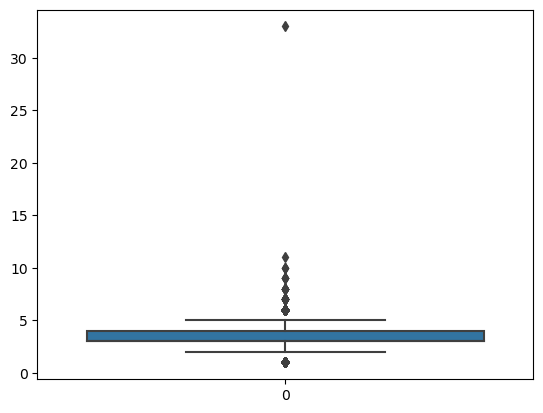

In [15]:
sns.boxplot(kc_preprocess['bedrooms'])
print(kc_preprocess['bathrooms'].value_counts())
kc_preprocess.describe()

In [16]:
bed_std = np.std(kc_preprocess['bedrooms']) * 3 
bed_mean = np.mean(kc_preprocess['bedrooms'])
bed_upperlimit = bed_mean + bed_std
bed_lowerlimit = bed_mean - bed_std

kc_data = kc_preprocess[(kc_preprocess['bedrooms'] < bed_upperlimit) & (kc_preprocess['bedrooms'] > bed_lowerlimit)]
kc_data.describe()



price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.153200e+04  21532.000000  21532.000000  21532.000000  2.153200e+04   
mean   5.390856e+05      3.359790      2.111381   2075.202536  1.509875e+04   
std    3.652339e+05      0.875134      0.762331    909.752552  4.142373e+04   
min    7.800000e+04      1.000000      0.500000    370.000000  5.200000e+02   
25%    3.210000e+05      3.000000      1.750000   1420.000000  5.040000e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.615500e+03   
75%    6.430005e+05      4.000000      2.500000   2540.000000  1.067050e+04   
max    7.700000e+06      6.000000      8.000000  12050.000000  1.651359e+06   

             floors    waterfront          view     condition         grade  \
count  21532.000000  21532.000000  21532.000000  21532.000000  21532.000000   
mean       1.493289      0.006781      0.232631      3.409716      7.656186   
std        0.539498      0.082067      0.763884      0.650451      1.171903   
min        1.000000      0.000000      0.000000      1.000000      3.000000   
25%        1.000000      0.000000      0.000000      3.000000      7.000000   
50%        1.500000      0.000000      0.000000      3.000000      7.000000   
75%        2.000000      0.000000      0.000000      4.000000      8.000000   
max        3.500000      1.000000      4.000000      5.000000     13.000000   

         sqft_above  sqft_basement     renovated  sqft_living15     sqft_lot15  
count  21532.000000   21532.000000  21532.000000   21532.000000   21532.000000  
mean    1785.200446     284.067481      0.034228    1985.801644   12760.370425  
std      823.293290     437.153807      0.181819     684.630809   27275.914740  
min      370.000000       0.000000      0.000000     399.000000     651.000000  
25%     1190.000000       0.000000      0.000000    1490.000000    5100.000000  
50%     1560.000000       0.000000      0.000000    1840.000000    7620.000000  
75%     2210.000000     540.000000      0.000000    2360.000000   10080.750000  
max     8860.000000    4820.000000      1.000000    6210.000000  871200.000000

In [17]:
bath_std = np.std(kc_data['bathrooms']) * 3 
bath_mean = np.mean(kc_data['bathrooms'])
bath_upperlimit = bath_mean + bath_std
bath_lowerlimit = abs(bath_mean - bath_std)

kc_data = kc_data[(kc_data['bathrooms'] < bath_upperlimit) & (kc_data['bathrooms'] > bath_lowerlimit)]
kc_data.describe()

price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.136000e+04  21360.000000  21360.000000  21360.000000  2.136000e+04   
mean   5.291362e+05      3.347893      2.089291   2051.297659  1.490721e+04   
std    3.295941e+05      0.865500      0.722499    861.876026  4.082657e+04   
min    7.800000e+04      1.000000      0.500000    370.000000  5.200000e+02   
25%    3.200000e+05      3.000000      1.500000   1420.000000  5.030000e+03   
50%    4.500000e+05      3.000000      2.250000   1900.000000  7.590000e+03   
75%    6.370000e+05      4.000000      2.500000   2520.000000  1.058400e+04   
max    4.490000e+06      6.000000      4.250000   7850.000000  1.651359e+06   

             floors   waterfront          view     condition         grade  \
count  21360.000000  21360.00000  21360.000000  21360.000000  21360.000000   
mean       1.489419      0.00618      0.225421      3.411330      7.635159   
std        0.538799      0.07837      0.750223      0.651291      1.144747   
min        1.000000      0.00000      0.000000      1.000000      3.000000   
25%        1.000000      0.00000      0.000000      3.000000      7.000000   
50%        1.500000      0.00000      0.000000      3.000000      7.000000   
75%        2.000000      0.00000      0.000000      4.000000      8.000000   
max        3.500000      1.00000      4.000000      5.000000     13.000000   

         sqft_above  sqft_basement     renovated  sqft_living15     sqft_lot15  
count  21360.000000   21360.000000  21360.000000   21360.000000   21360.000000  
mean    1765.779354     279.785908      0.033801    1976.082772   12635.301639  
std      788.812770     429.022253      0.180722     672.294176   26550.686205  
min      370.000000       0.000000      0.000000     399.000000     651.000000  
25%     1190.000000       0.000000      0.000000    1480.000000    5100.000000  
50%     1550.000000       0.000000      0.000000    1830.000000    7611.000000  
75%     2190.000000     530.000000      0.000000    2350.000000   10039.000000  
max     7850.000000    3500.000000      1.000000    6210.000000  871200.000000

# Identify dependant variable

In [18]:
kc_data.corr()

price  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
price          1.000000  0.302114   0.489143     0.677598  0.083726  0.257636   
bedrooms       0.302114  1.000000   0.509310     0.590509  0.030363  0.174153   
bathrooms      0.489143  0.509310   1.000000     0.732187  0.073650  0.509873   
sqft_living    0.677598  0.590509   0.732187     1.000000  0.161974  0.351518   
sqft_lot       0.083726  0.030363   0.073650     0.161974  1.000000 -0.009441   
floors         0.257636  0.174153   0.509873     0.351518 -0.009441  1.000000   
waterfront     0.236415 -0.013061   0.041313     0.081218  0.021798  0.017626   
view           0.386814  0.069429   0.161226     0.262273  0.068579  0.020668   
condition      0.045710  0.028689  -0.124993    -0.055087 -0.006549 -0.264508   
grade          0.668349  0.360983   0.653819     0.755249  0.104087  0.457041   
sqft_above     0.578365  0.483117   0.659755     0.866890  0.172169  0.528232   
sqft_basement  0.293814  0.291067   0.252368     0.406679  0.008365 -0.259730   
renovated      0.114207  0.009525   0.037751     0.042722  0.005674  0.000548   
sqft_living15  0.593681  0.407271   0.563092     0.762593  0.141887  0.275188   
sqft_lot15     0.077567  0.029423   0.074875     0.176784  0.710711 -0.016083   

               waterfront      view  condition     grade  sqft_above  \
price            0.236415  0.386814   0.045710  0.668349    0.578365   
bedrooms        -0.013061  0.069429   0.028689  0.360983    0.483117   
bathrooms        0.041313  0.161226  -0.124993  0.653819    0.659755   
sqft_living      0.081218  0.262273  -0.055087  0.755249    0.866890   
sqft_lot         0.021798  0.068579  -0.006549  0.104087    0.172169   
floors           0.017626  0.020668  -0.264508  0.457041    0.528232   
waterfront       1.000000  0.374457   0.017157  0.068969    0.054405   
view             0.374457  1.000000   0.046994  0.232165    0.144080   
condition        0.017157  0.046994   1.000000 -0.146159   -0.159707   
grade            0.068969  0.232165  -0.146159  1.000000    0.746676   
sqft_above       0.054405  0.144080  -0.159707  0.746676    1.000000   
sqft_basement    0.062652  0.256682   0.176553  0.141698   -0.094796   
renovated        0.067892  0.087105  -0.056475  0.009599    0.013697   
sqft_living15    0.073470  0.267357  -0.091902  0.706392    0.733202   
sqft_lot15       0.032104  0.065792  -0.000310  0.112706    0.186681   

               sqft_basement  renovated  sqft_living15  sqft_lot15  
price               0.293814   0.114207       0.593681    0.077567  
bedrooms            0.291067   0.009525       0.407271    0.029423  
bathrooms           0.252368   0.037751       0.563092    0.074875  
sqft_living         0.406679   0.042722       0.762593    0.176784  
sqft_lot            0.008365   0.005674       0.141887    0.710711  
floors             -0.259730   0.000548       0.275188   -0.016083  
waterfront          0.062652   0.067892       0.073470    0.032104  
view                0.256682   0.087105       0.267357    0.065792  
condition           0.176553  -0.056475      -0.091902   -0.000310  
grade               0.141698   0.009599       0.706392    0.112706  
sqft_above         -0.094796   0.013697       0.733202    0.186681  
sqft_basement       1.000000   0.059175       0.181672    0.010089  
renovated           0.059175   1.000000      -0.003112    0.005455  
sqft_living15       0.181672  -0.003112       1.000000    0.182882  
sqft_lot15          0.010089   0.005455       0.182882    1.000000

In [19]:
len(kc_data.columns)

15

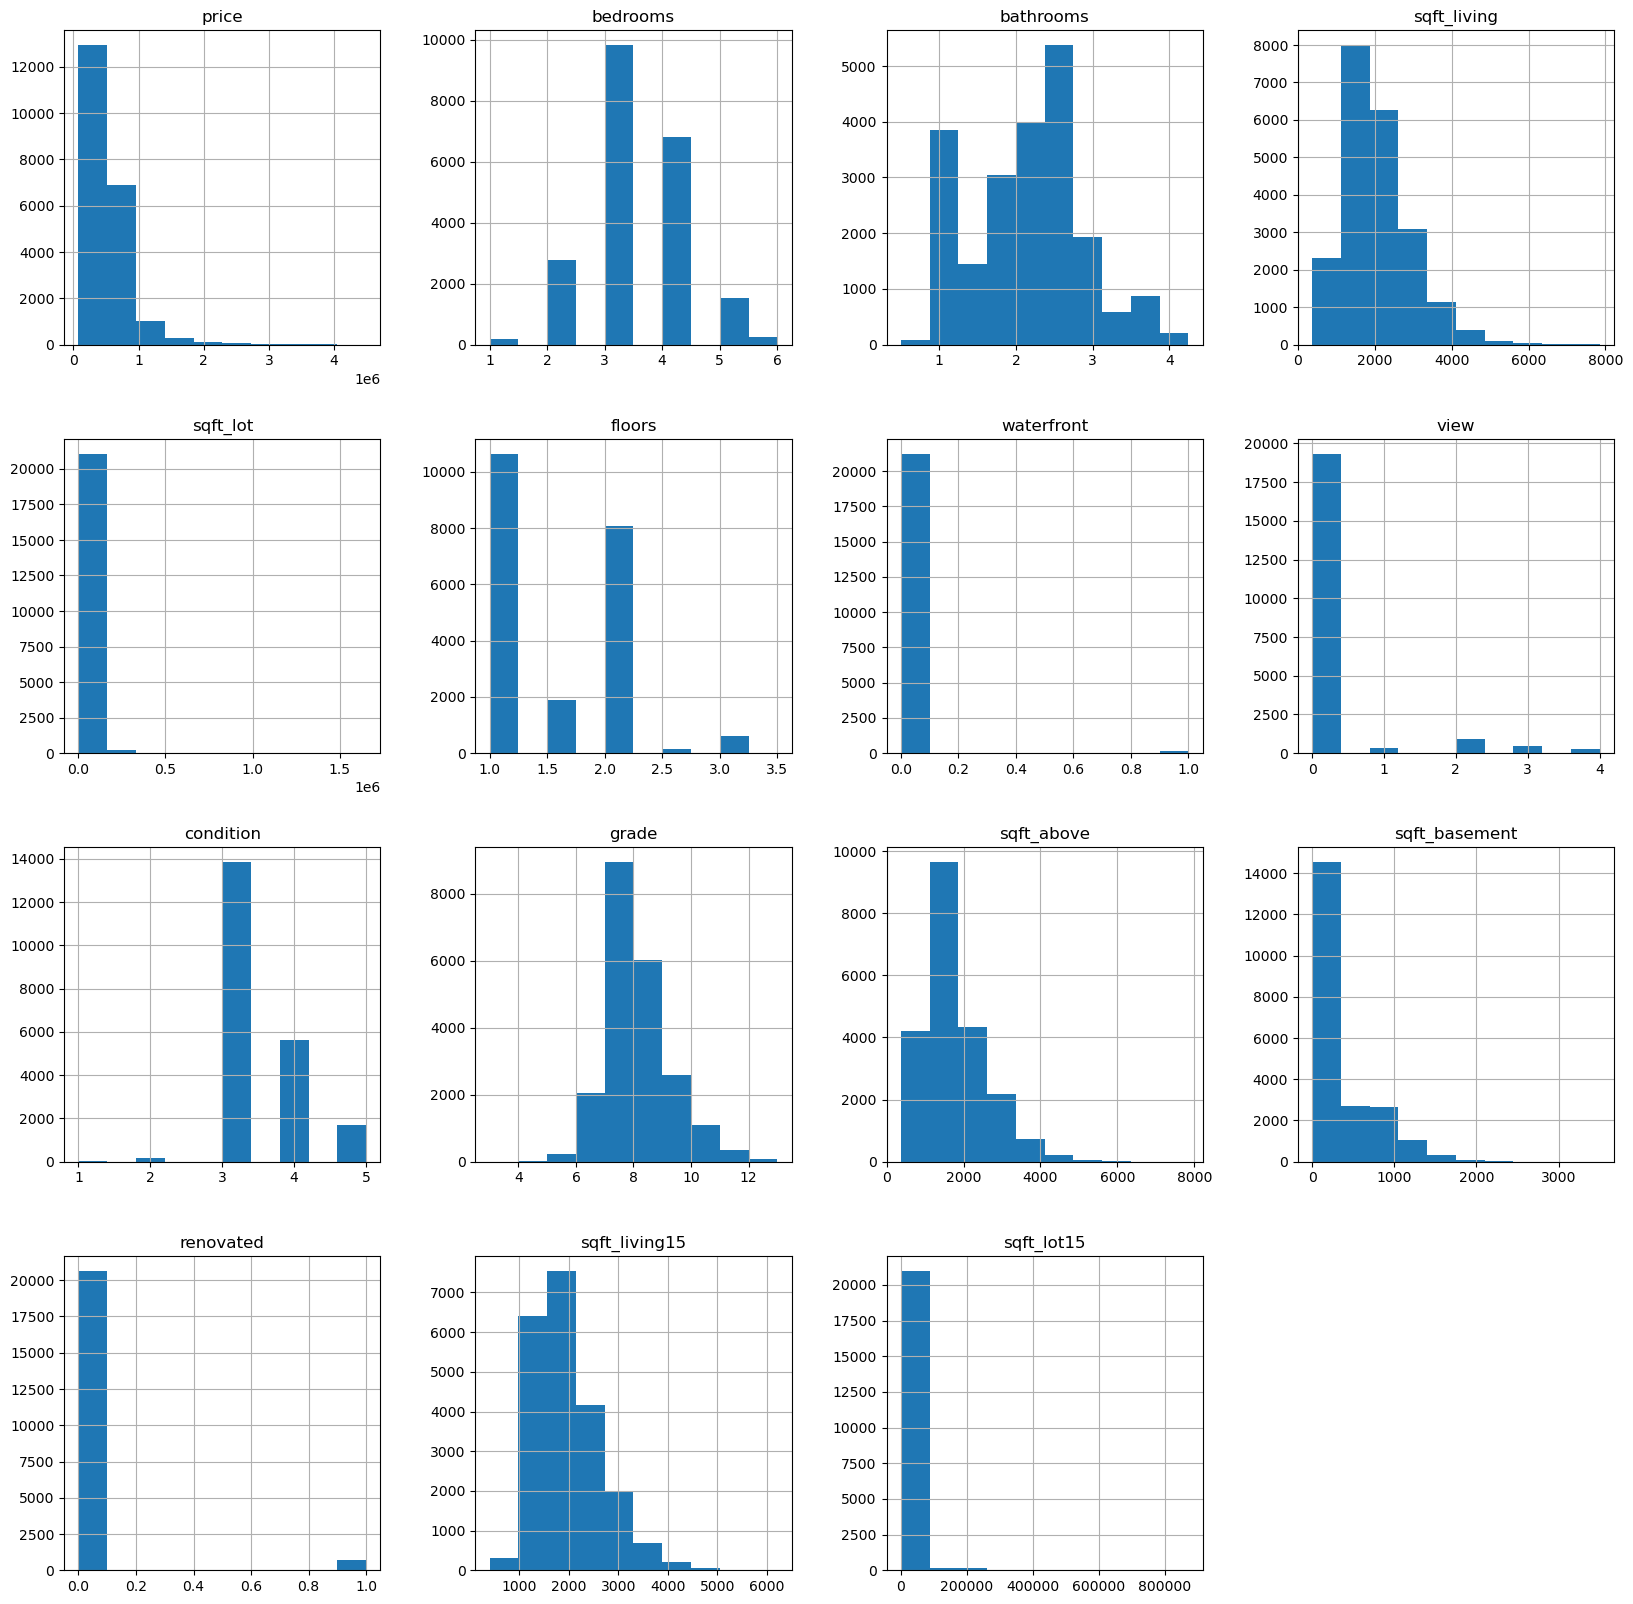

In [20]:
'''check histogram then use log and check again'''
kc_data.hist(figsize=(20,20));

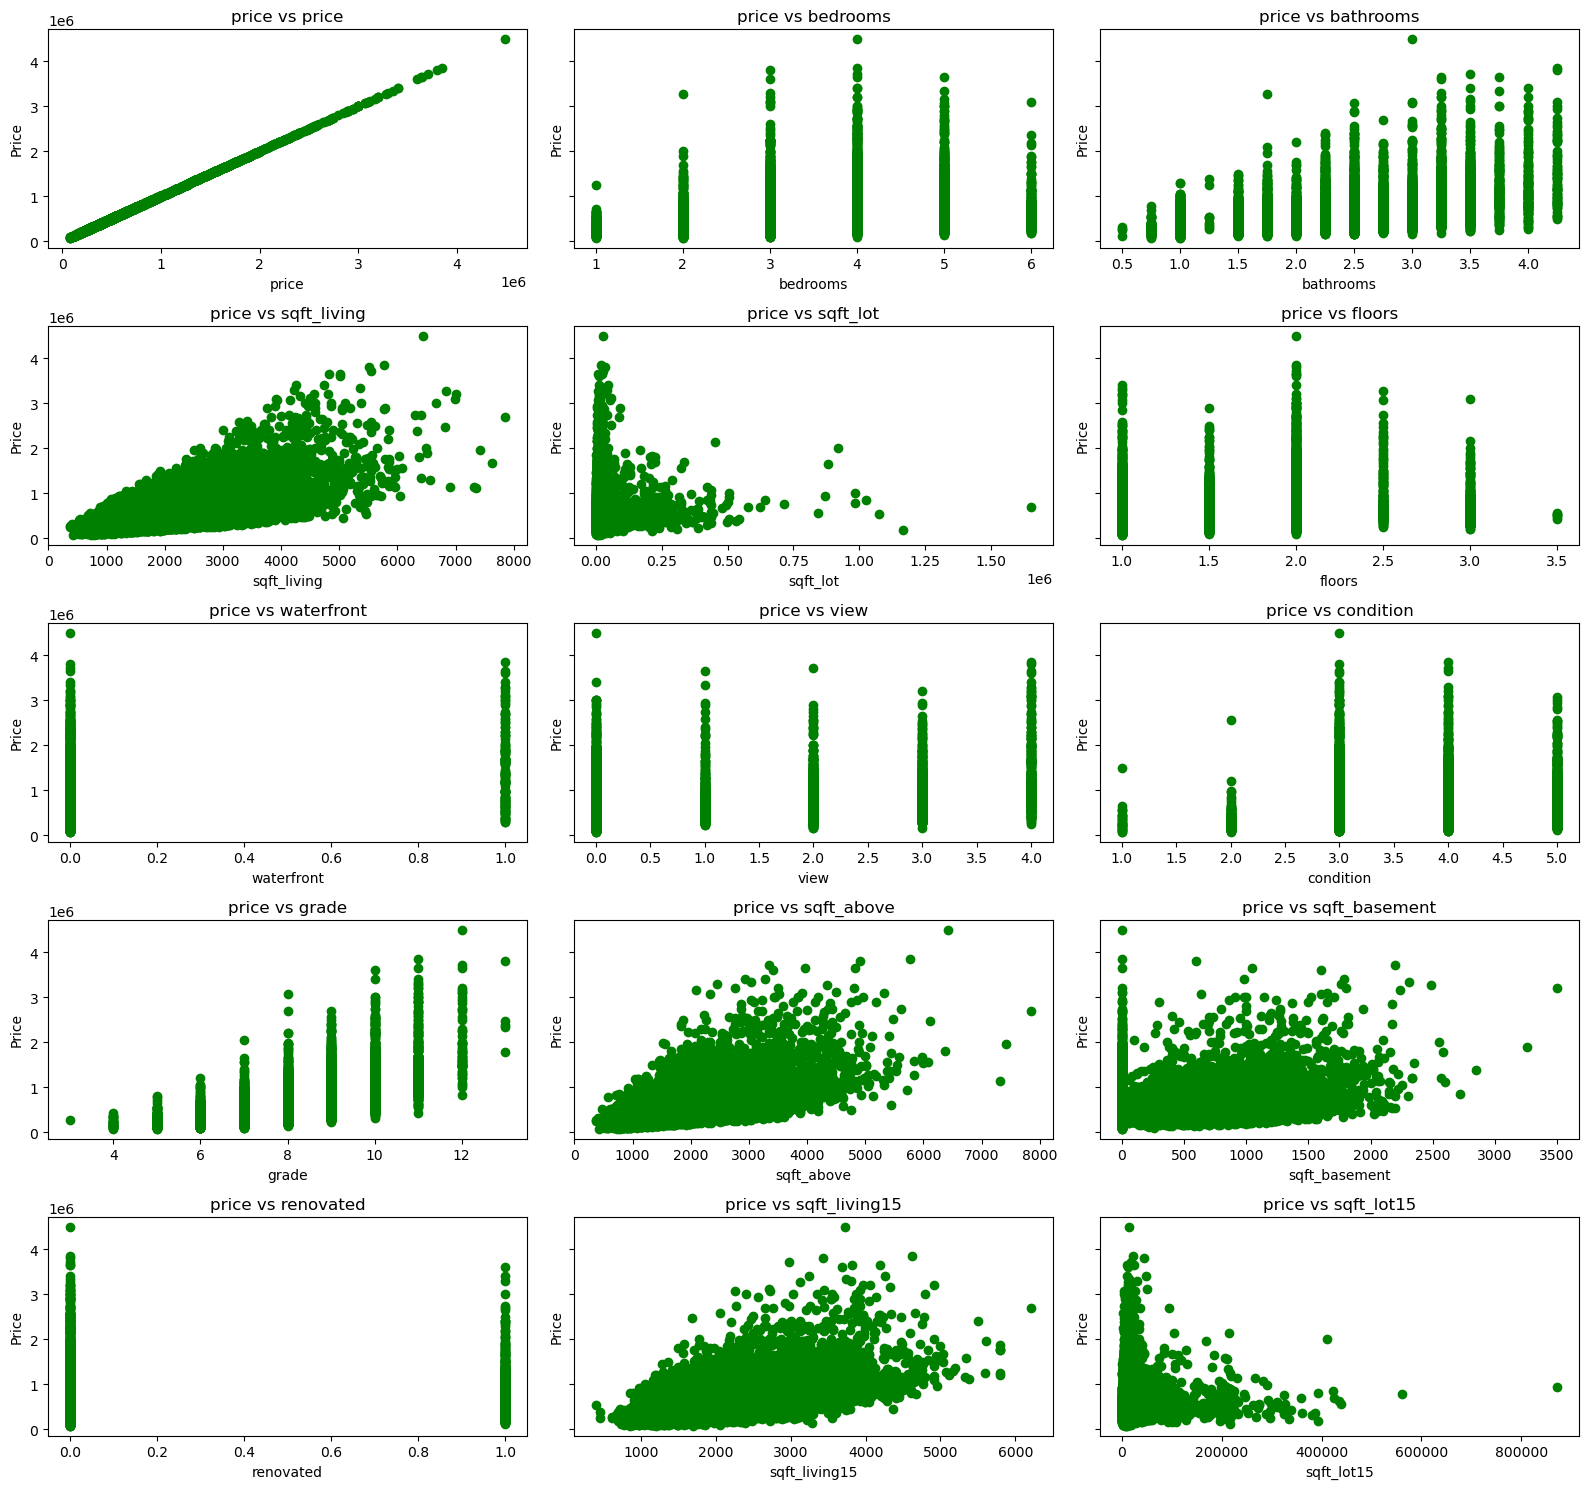

In [21]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(16,15), sharey=True )

for ax, column in zip(axes.flatten(), kc_data.columns[:]):
    ax.scatter(kc_data[column], kc_data['price'], color = 'g')
    ax.set_title(f'price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Price')
fig.tight_layout()

<Axes: xlabel='floors', ylabel='price'>

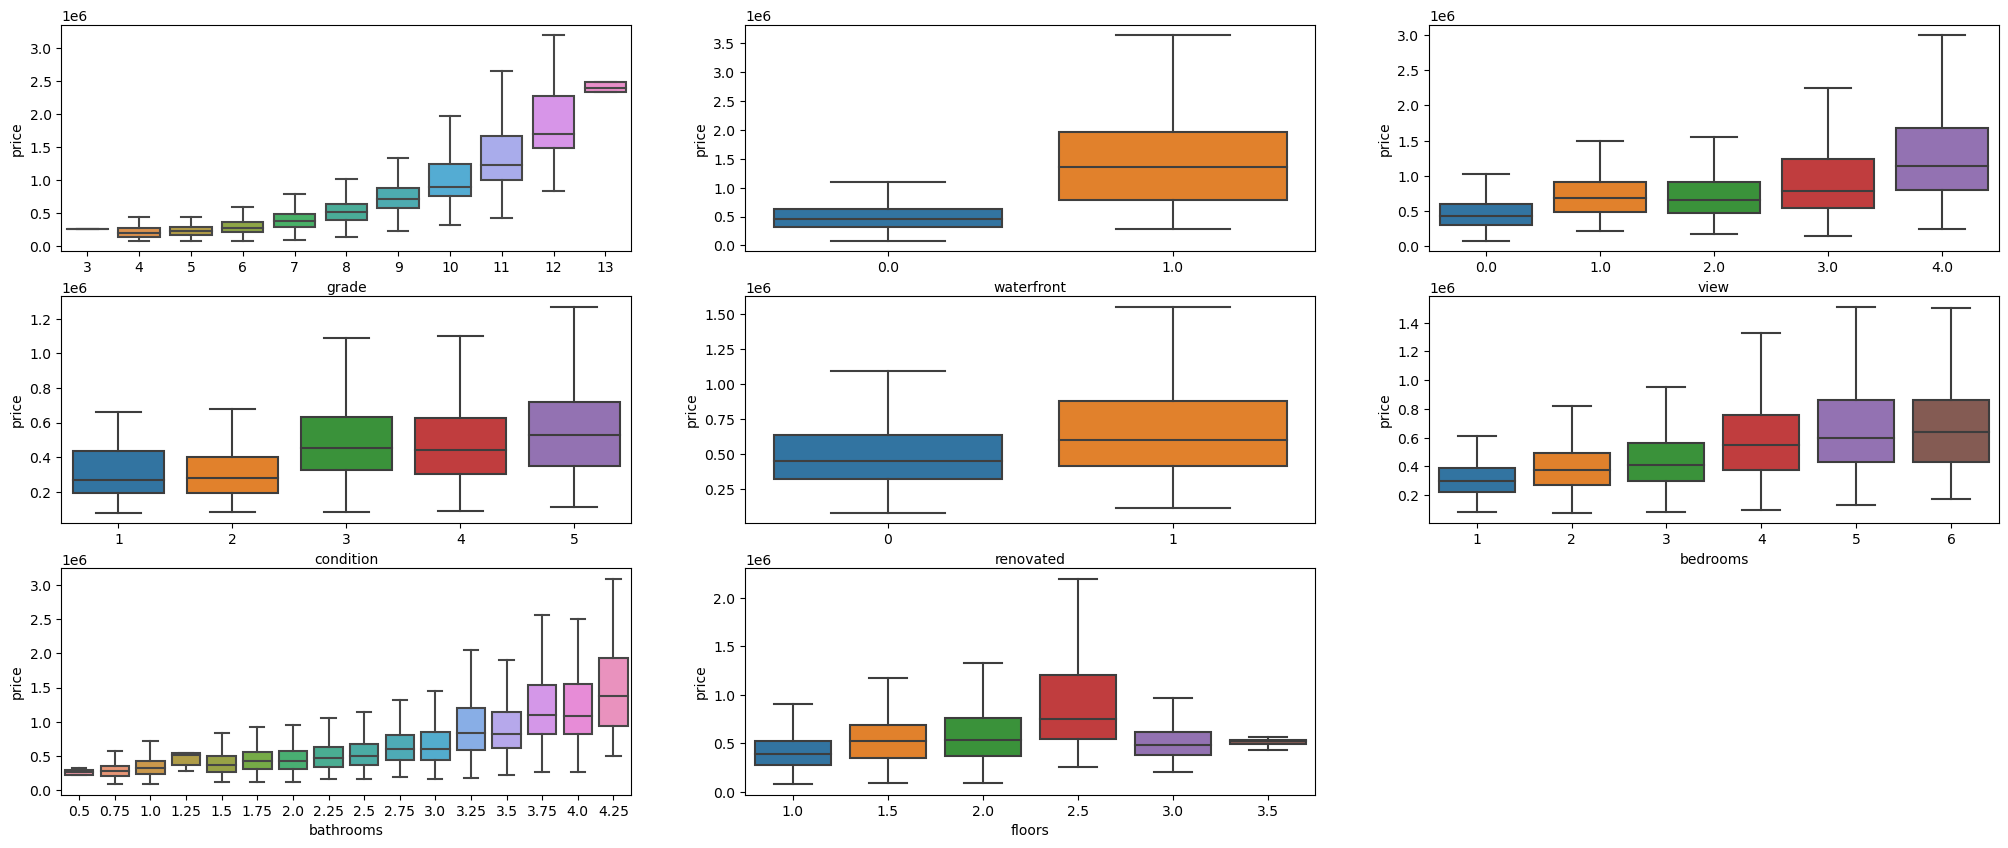

In [22]:
plt.figure(figsize=(25, 10))
plt.subplot(3,3,1)
sns.boxplot(x = 'grade', y = 'price', data = kc_data,  showfliers=False)
plt.subplot(3,3,2)
sns.boxplot(x = 'waterfront', y = 'price', data = kc_data, showfliers=False)
plt.subplot(3,3,3)
sns.boxplot(x = 'view', y = 'price', data = kc_data, showfliers=False)
plt.subplot(3,3,4)
sns.boxplot(x = 'condition', y = 'price', data = kc_data,  showfliers=False)
plt.subplot(3,3,5)
sns.boxplot(x = 'renovated', y = 'price', data = kc_data,  showfliers=False)
plt.subplot(3,3,6)
sns.boxplot(x = 'bedrooms', y = 'price', data = kc_data,  showfliers=False)
plt.subplot(3,3,7)
sns.boxplot(x = 'bathrooms', y = 'price', data = kc_data,  showfliers=False)
plt.subplot(3,3,8)
sns.boxplot(x = 'floors', y = 'price', data = kc_data,  showfliers=False)



In [23]:
kc_data['bedrooms']=kc_data['bedrooms'].astype('category')
kc_data['bathrooms']=kc_data['bathrooms'].astype('category')
kc_data['floors']=kc_data['floors'].astype('category')
kc_data['grade']=kc_data['grade'].astype('category')

kc_data['view']=kc_data['view'].astype('category')
kc_data['condition']=kc_data['condition'].astype('category')
kc_data['renovated']=kc_data['renovated'].astype('category')

kc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21360 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   price          21360 non-null  float64 
 1   bedrooms       21360 non-null  category
 2   bathrooms      21360 non-null  category
 3   sqft_living    21360 non-null  int64   
 4   sqft_lot       21360 non-null  int64   
 5   floors         21360 non-null  category
 6   waterfront     21360 non-null  float64 
 7   view           21360 non-null  category
 8   condition      21360 non-null  category
 9   grade          21360 non-null  category
 10  sqft_above     21360 non-null  int64   
 11  sqft_basement  21360 non-null  float64 
 12  renovated      21360 non-null  category
 13  sqft_living15  21360 non-null  int64   
 14  sqft_lot15     21360 non-null  int64   
dtypes: category(7), float64(3), int64(5)
memory usage: 1.6 MB


In [24]:
'''
Categorical Variables
'''
bed_dummy = pd.get_dummies(kc_data['bedrooms'], prefix = 'bedrooms', drop_first=True, dtype = 'int') 
#drop a column to avoid dummy variable trap
kc_data = kc_data.drop('bedrooms', axis = 1)
kc_data = kc_data.join(bed_dummy)

bath_dummy = pd.get_dummies(kc_data['bathrooms'], prefix = 'bathroom', drop_first=True, dtype = 'int') #drop a column to avoid dummy variable trap
bath_dummy = bath_dummy.rename(columns = {'bathroom_0.75':'bathroom0_75', 'bathroom_1.0':'bathroom1_0', 'bathroom_1.25':'bathroom1_25', 'bathroom_1.5':'bathroom1_5',
       'bathroom_1.75':'bathroom1_75', 'bathroom_2.0':'bathroom2_0', 'bathroom_2.25':'bathroom2_25', 'bathroom_2.5':'bathroom2_5',
       'bathroom_2.75':'bathroom2_75', 'bathroom_3.0':'bathroom3_0', 'bathroom_3.25':'bathroom3_25', 'bathroom_3.5':'bathroom3_5',
       'bathroom_3.75':'bathroom3_75', 'bathroom_4.0':'bathroom4_0', 'bathroom_4.25':'bathroom4_25'})
kc_data = kc_data.drop('bathrooms', axis = 1)
kc_data = kc_data.join(bath_dummy)

floor_dummy = pd.get_dummies(kc_data['floors'], prefix = 'floors', drop_first=True, dtype = 'int') #drop a column to avoid dummy variable trap
floor_dummy = floor_dummy.rename(columns = {'floors_1.5':'floor1_5', 'floors_2.0':'floor2_0', 'floors_2.5':'floor2_5', 'floors_3.0':'floor3_0', 'floors_3.5':'floor3_5'})
kc_data = kc_data.drop('floors', axis = 1)
kc_data = kc_data.join(floor_dummy)

grade_dummy = pd.get_dummies(kc_data['grade'], prefix = 'grade', drop_first=True, dtype = 'int') #drop a column to avoid dummy variable trap
kc_data = kc_data.drop('grade', axis = 1)
kc_data = kc_data.join(grade_dummy)

waterfront_dummy = pd.get_dummies(kc_data['waterfront'], prefix = 'waterfront', drop_first=True, dtype = 'int') #drop a column to avoid dummy variable trap
waterfront_dummy = waterfront_dummy.rename(columns = {'waterfront_1.0':'waterfront1'})
kc_data = kc_data.drop('waterfront', axis = 1)
kc_data = kc_data.join(waterfront_dummy)

view_dummy = pd.get_dummies(kc_data['view'], prefix = 'view', drop_first=True, dtype = 'int')
view_dummy = view_dummy.rename(columns = {'view_1.0':'view1', 'view_2.0':'view2', 'view_3.0':'view3','view_4.0':'view4'})
kc_data = kc_data.drop('view', axis = 1)
kc_data = kc_data.join(view_dummy)

cond_dummy = pd.get_dummies(kc_data['condition'], prefix = 'cond', drop_first=True, dtype = 'int')
cond_dummy = cond_dummy.rename(columns = {'cond_1':'cond1', 'cond_2':'cond2', 'cond_3':'cond3','cond_4':'cond4','cond_5':'cond5'})
kc_data = kc_data.drop('condition', axis = 1)
kc_data = kc_data.join(cond_dummy)

renovated_dummy = pd.get_dummies(kc_data['renovated'], prefix = 'renovated', drop_first=True, dtype = 'int')
kc_data = kc_data.drop('renovated', axis = 1)
kc_data = kc_data.join(renovated_dummy)

display(kc_data.head())


price  sqft_living  sqft_lot  sqft_above  sqft_basement  sqft_living15  \
0  221900.0         1180      5650        1180            0.0           1340   
1  538000.0         2570      7242        2170          400.0           1690   
2  180000.0          770     10000         770            0.0           2720   
3  604000.0         1960      5000        1050          910.0           1360   
4  510000.0         1680      8080        1680            0.0           1800   

   sqft_lot15  bedrooms_2  bedrooms_3  bedrooms_4  ...  waterfront1  view1  \
0        5650           0           1           0  ...            0      0   
1        7639           0           1           0  ...            0      0   
2        8062           1           0           0  ...            0      0   
3        5000           0           0           1  ...            0      0   
4        7503           0           1           0  ...            0      0   

   view2  view3  view4  cond2  cond3  cond4  cond5  renovated_1  
0      0      0      0      0      1      0      0            0  
1      0      0      0      0      1      0      0            1  
2      0      0      0      0      1      0      0            0  
3      0      0      0      0      0      0      1            0  
4      0      0      0      0      1      0      0            0  

[5 rows x 52 columns]

In [25]:
kc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21360 entries, 0 to 21596
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21360 non-null  float64
 1   sqft_living    21360 non-null  int64  
 2   sqft_lot       21360 non-null  int64  
 3   sqft_above     21360 non-null  int64  
 4   sqft_basement  21360 non-null  float64
 5   sqft_living15  21360 non-null  int64  
 6   sqft_lot15     21360 non-null  int64  
 7   bedrooms_2     21360 non-null  int32  
 8   bedrooms_3     21360 non-null  int32  
 9   bedrooms_4     21360 non-null  int32  
 10  bedrooms_5     21360 non-null  int32  
 11  bedrooms_6     21360 non-null  int32  
 12  bathroom0_75   21360 non-null  int32  
 13  bathroom1_0    21360 non-null  int32  
 14  bathroom1_25   21360 non-null  int32  
 15  bathroom1_5    21360 non-null  int32  
 16  bathroom1_75   21360 non-null  int32  
 17  bathroom2_0    21360 non-null  int32  
 18  bathroom2_2

# Log-Transform & Homoscedascity Check

In [26]:
'''
Log Transform
'''
continuous_varr = [ 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15','sqft_basement','sqft_lot15']
continuous_varr

['sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_living15',
 'sqft_basement',
 'sqft_lot15']

In [27]:
log_varr = ['price','sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15',
       'sqft_lot15']

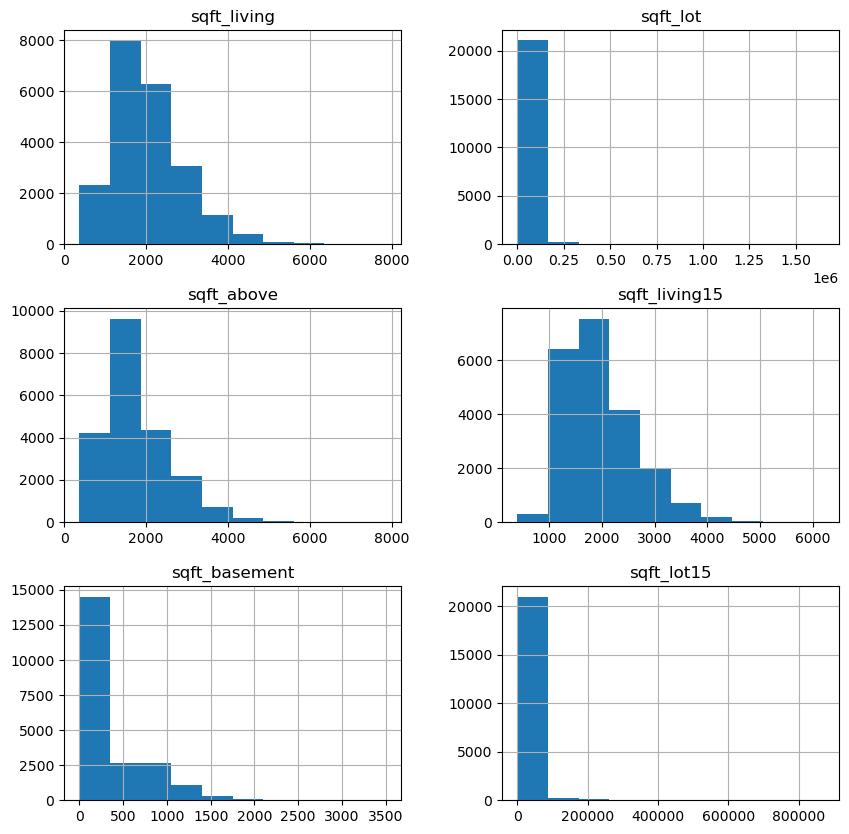

In [28]:
kc_data[continuous_varr].hist(figsize=(10,10));

<Axes: xlabel='sqft_basement', ylabel='price'>

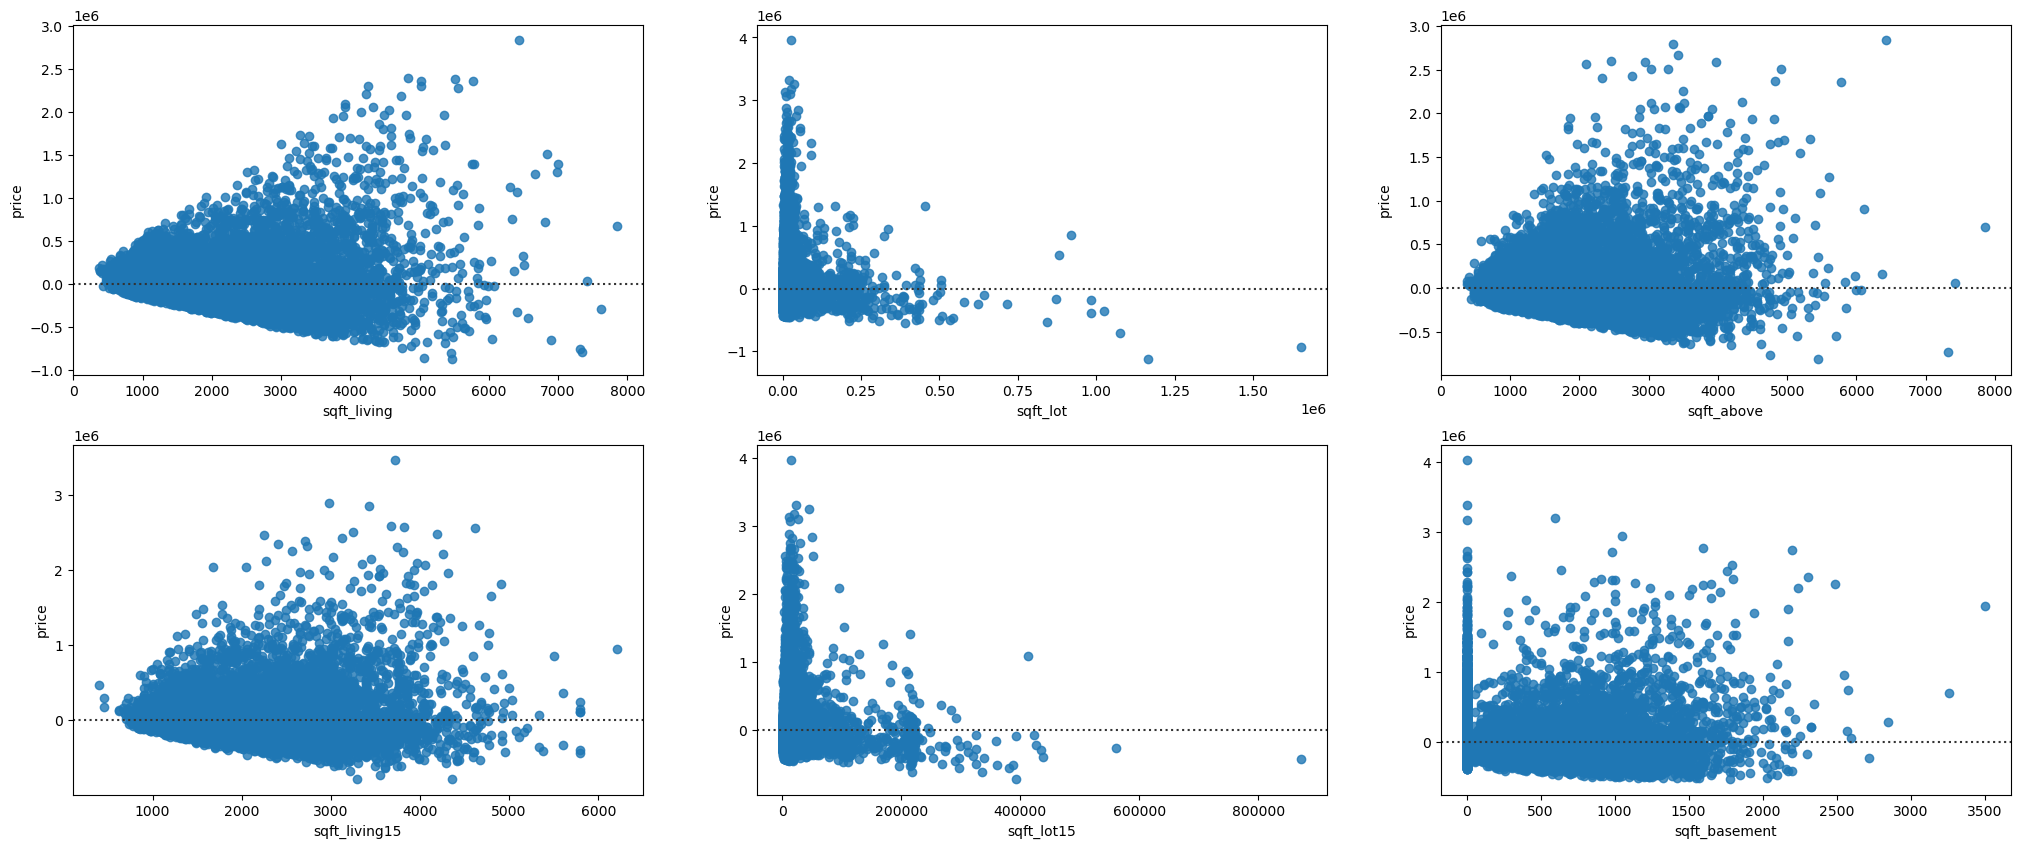

In [29]:
plt.figure(figsize=(25, 10))
plt.subplot(2,3,1)
sns.residplot(x = 'sqft_living', y = 'price', data = kc_data)
plt.subplot(2,3,2)
sns.residplot(x = 'sqft_lot', y = 'price', data = kc_data)
plt.subplot(2,3,3)
sns.residplot(x = 'sqft_above', y = 'price', data = kc_data)
plt.subplot(2,3,4)
sns.residplot(x = 'sqft_living15', y = 'price', data = kc_data)
plt.subplot(2,3,5)
sns.residplot(x = 'sqft_lot15', y = 'price', data = kc_data)
plt.subplot(2,3,6)
sns.residplot(x = 'sqft_basement', y = 'price', data = kc_data)

In [30]:
kc_data[log_varr] = np.log(kc_data[log_varr])
            
kc_data.head()

price  sqft_living  sqft_lot  sqft_above  sqft_basement  sqft_living15  \
0  12.309982     7.073270  8.639411    7.073270            0.0       7.200425   
1  13.195614     7.851661  8.887653    7.682482          400.0       7.432484   
2  12.100712     6.646391  9.210340    6.646391            0.0       7.908387   
3  13.311329     7.580700  8.517193    6.956545          910.0       7.215240   
4  13.142166     7.426549  8.997147    7.426549            0.0       7.495542   

   sqft_lot15  bedrooms_2  bedrooms_3  bedrooms_4  ...  waterfront1  view1  \
0    8.639411           0           1           0  ...            0      0   
1    8.941022           0           1           0  ...            0      0   
2    8.994917           1           0           0  ...            0      0   
3    8.517193           0           0           1  ...            0      0   
4    8.923058           0           1           0  ...            0      0   

   view2  view3  view4  cond2  cond3  cond4  cond5  renovated_1  
0      0      0      0      0      1      0      0            0  
1      0      0      0      0      1      0      0            1  
2      0      0      0      0      1      0      0            0  
3      0      0      0      0      0      0      1            0  
4      0      0      0      0      1      0      0            0  

[5 rows x 52 columns]

array([[<Axes: title={'center': 'sqft_living'}>,
        <Axes: title={'center': 'sqft_lot'}>],
       [<Axes: title={'center': 'sqft_above'}>,
        <Axes: title={'center': 'sqft_living15'}>],
       [<Axes: title={'center': 'sqft_basement'}>,
        <Axes: title={'center': 'sqft_lot15'}>]], dtype=object)

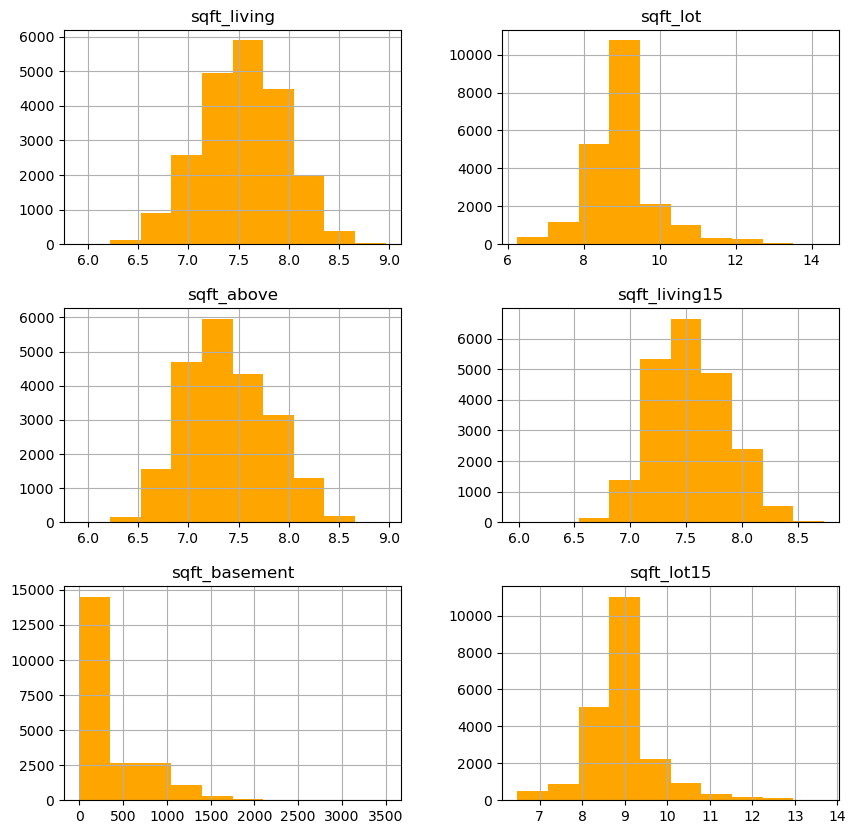

In [31]:
kc_data[continuous_varr].hist(figsize=(10,10), color = 'orange')

<Axes: xlabel='sqft_basement', ylabel='price'>

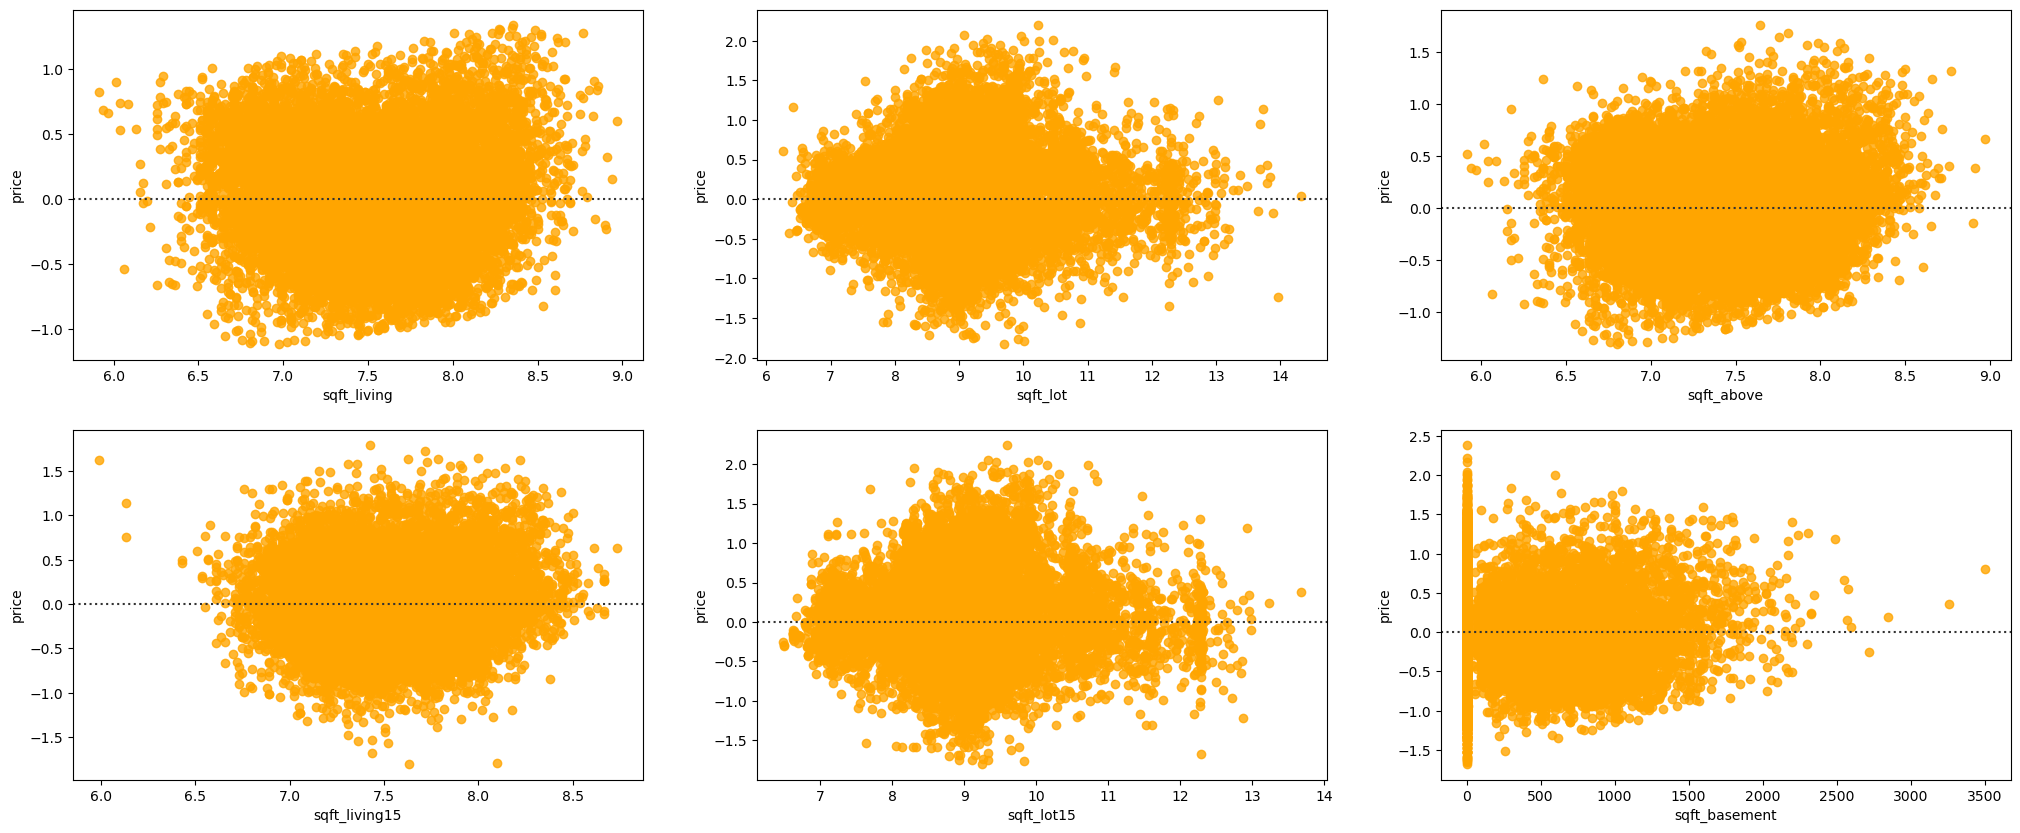

In [32]:
plt.figure(figsize=(25, 10))
plt.subplot(2,3,1)
sns.residplot(x = 'sqft_living', y = 'price', data = kc_data, color = 'orange')
plt.subplot(2,3,2)
sns.residplot(x = 'sqft_lot', y = 'price', data = kc_data, color = 'orange')
plt.subplot(2,3,3)
sns.residplot(x = 'sqft_above', y = 'price', data = kc_data, color = 'orange')
plt.subplot(2,3,4)
sns.residplot(x = 'sqft_living15', y = 'price', data = kc_data, color = 'orange')
plt.subplot(2,3,5)
sns.residplot(x = 'sqft_lot15', y = 'price', data = kc_data, color = 'orange')
plt.subplot(2,3,6)
sns.residplot(x = 'sqft_basement', y = 'price', data = kc_data, color = 'orange')

In [33]:
scaler = MinMaxScaler()

kc_data[continuous_varr] = scaler.fit_transform(kc_data[continuous_varr])
kc_data.head()

price  sqft_living  sqft_lot  sqft_above  sqft_basement  sqft_living15  \
0  12.309982     0.379658  0.295858    0.379658       0.000000       0.441342   
1  13.195614     0.634470  0.326644    0.579088       0.114286       0.525882   
2  12.100712     0.239916  0.366664    0.239916       0.000000       0.699256   
3  13.311329     0.545769  0.280700    0.341448       0.260000       0.446739   
4  13.142166     0.495307  0.340224    0.495307       0.000000       0.548854   

   sqft_lot15  bedrooms_2  bedrooms_3  bedrooms_4  ...  waterfront1  view1  \
0    0.300162           0           1           0  ...            0      0   
1    0.342058           0           1           0  ...            0      0   
2    0.349544           1           0           0  ...            0      0   
3    0.283185           0           0           1  ...            0      0   
4    0.339562           0           1           0  ...            0      0   

   view2  view3  view4  cond2  cond3  cond4  cond5  renovated_1  
0      0      0      0      0      1      0      0            0  
1      0      0      0      0      1      0      0            1  
2      0      0      0      0      1      0      0            0  
3      0      0      0      0      0      0      1            0  
4      0      0      0      0      1      0      0            0  

[5 rows x 52 columns]

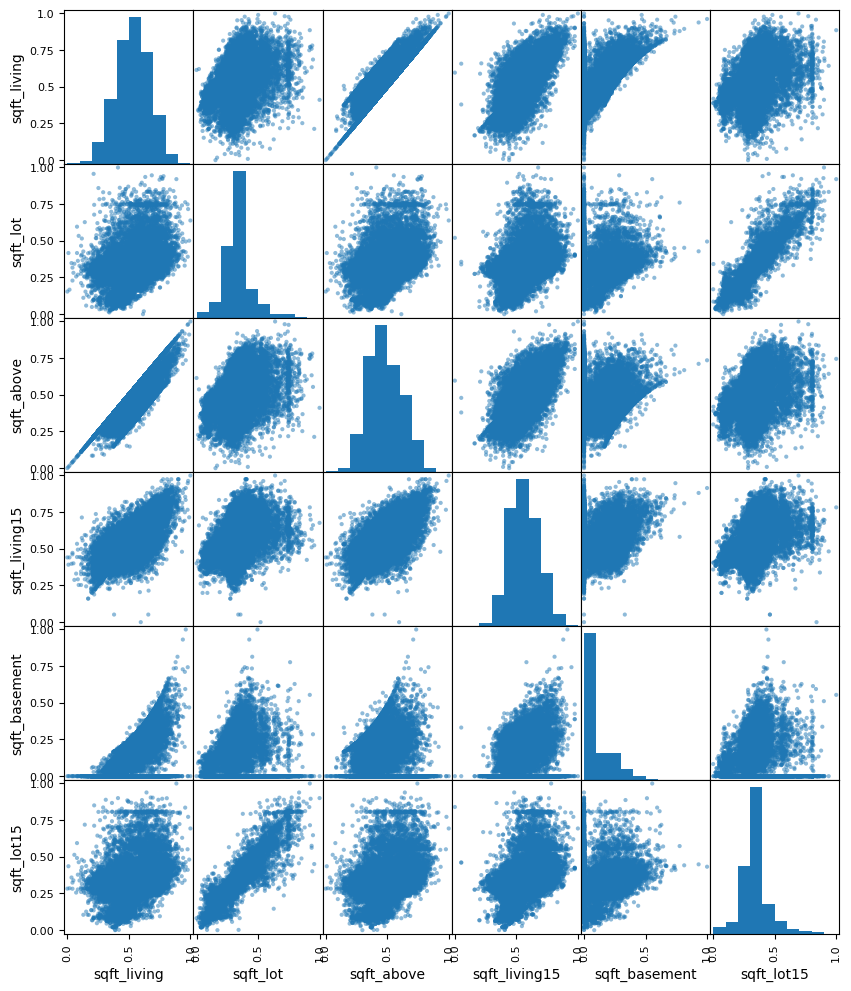

In [34]:
pd.plotting.scatter_matrix(kc_data[continuous_varr], figsize=(10,12))
plt.show()

<Axes: >

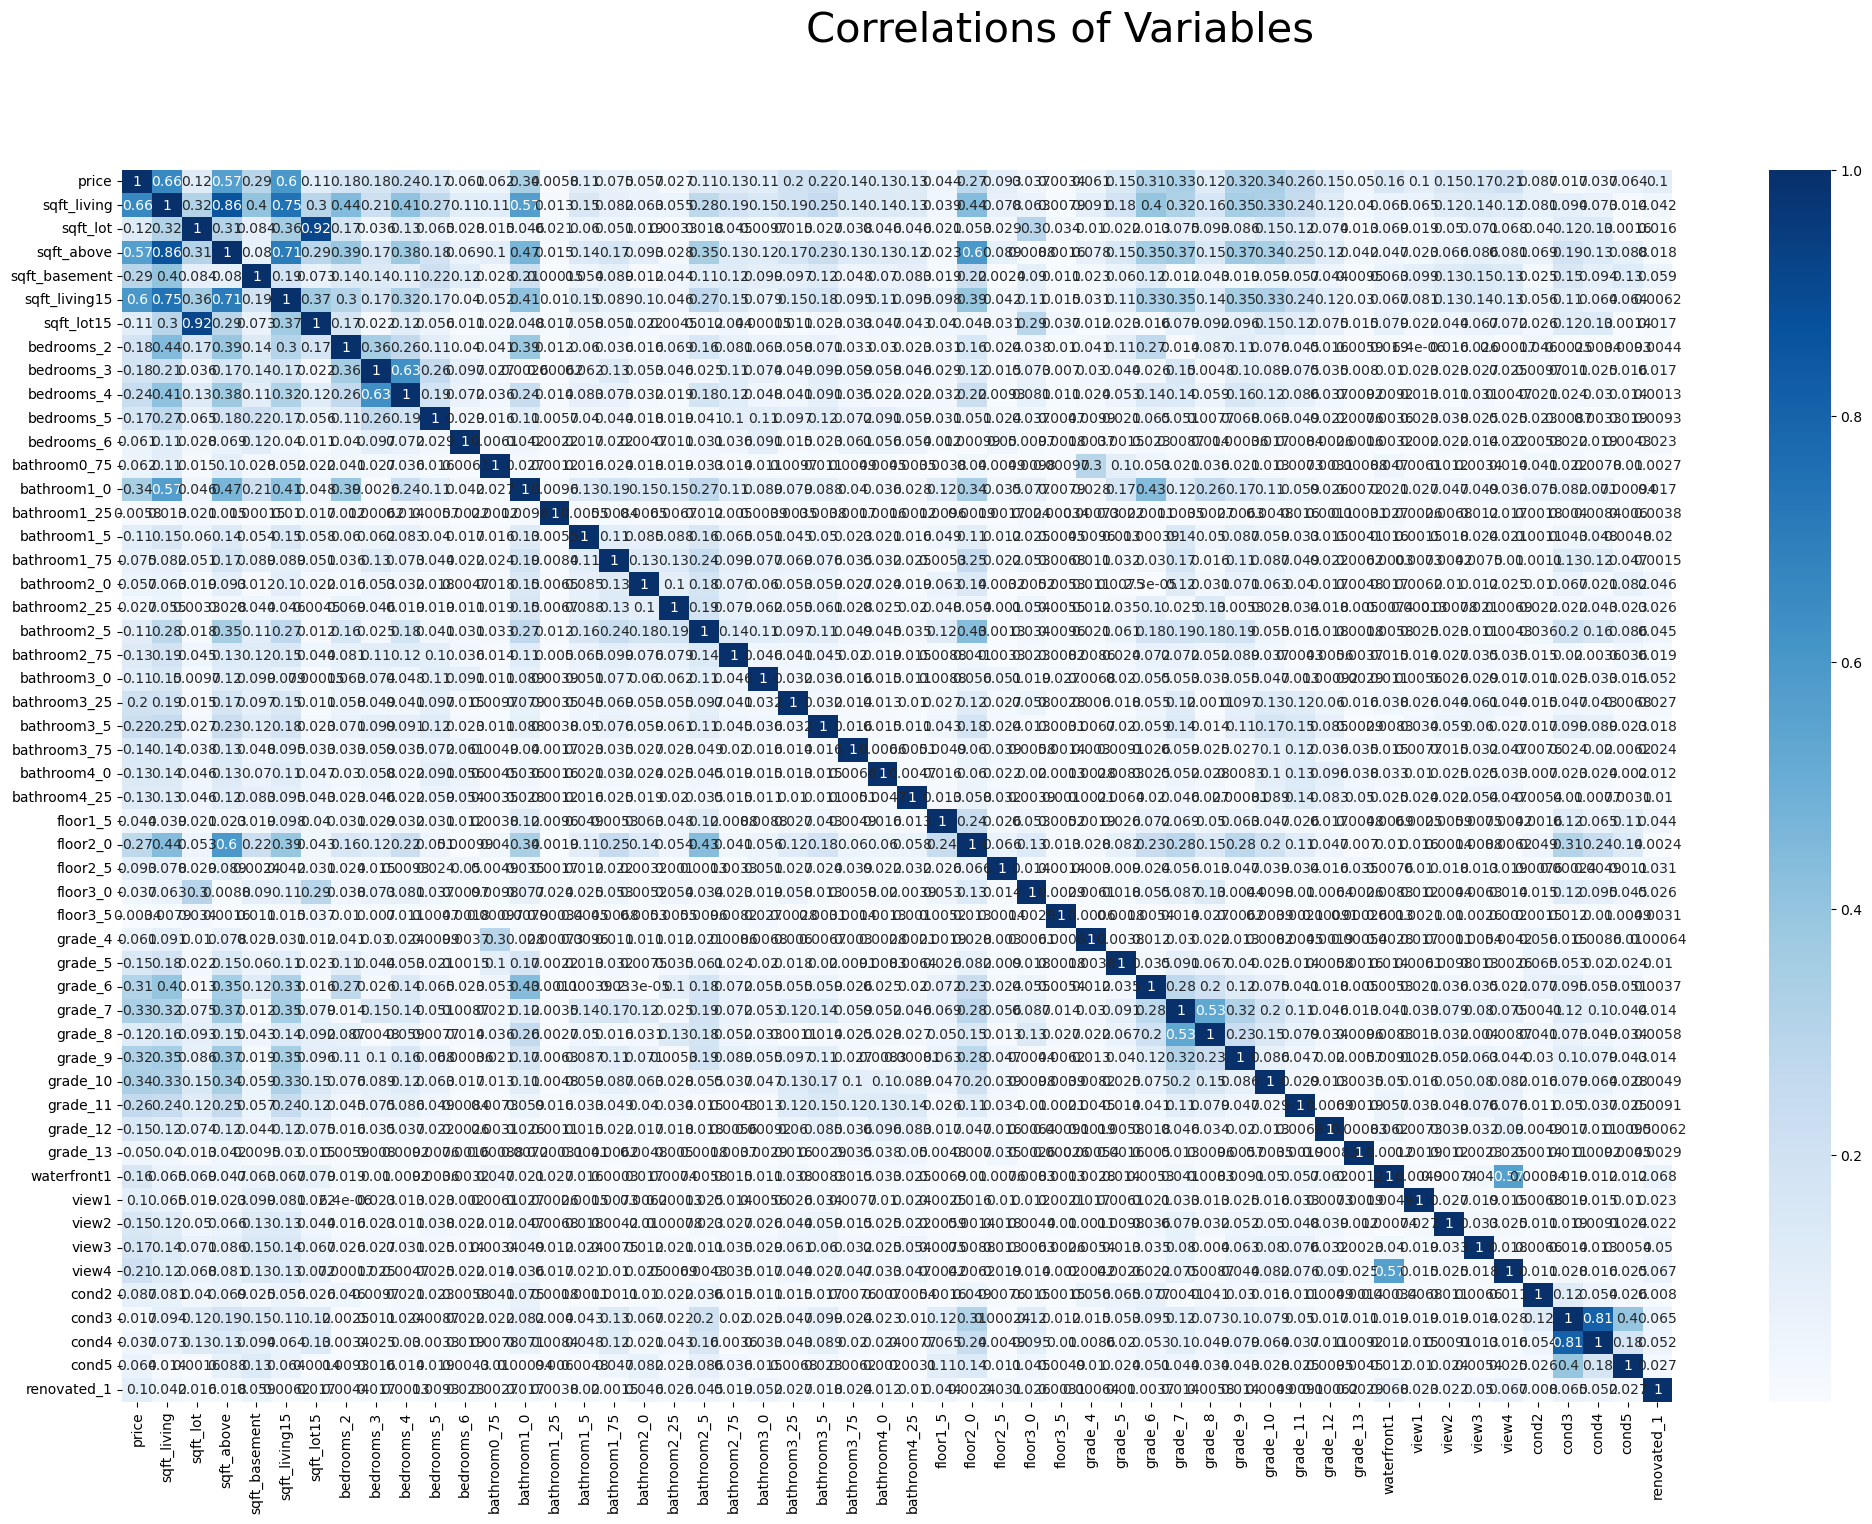

In [35]:
corr_var = kc_data.corr().abs()
fig, ax=plt.subplots(figsize=(25,16))
fig.suptitle('Correlations of Variables', fontsize=30)
heatmap = sns.heatmap(corr_var, cmap='Blues', annot=True)
heatmap

In [36]:
'''
checking multicolinearity between independant variables from the heatmap
'''

features_multicor = []
correlations_multicor = []
    
for column in corr_var:                                           #for each variable(column) in the 
    for index, correlation in corr_var[column].items():             #for index & correlation(data) in the column
        if correlation >= .70 and index != column:
            features_multicor.append([column, index])
            correlations_multicor.append(correlation)
            
MC_df = pd.DataFrame({'Correlations':correlations_multicor, 'Features': features_multicor}).sort_values(by=['Correlations'], ascending=False)
MC_df.drop_duplicates('Correlations')

Correlations                      Features
2      0.919473        [sqft_lot, sqft_lot15]
0      0.859457     [sqft_living, sqft_above]
8      0.812092                [cond3, cond4]
1      0.745434  [sqft_living, sqft_living15]
4      0.710436   [sqft_above, sqft_living15]

## Building the model

In [37]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(kc_data, train_size = 0.70, test_size = 0.30, random_state = 333)

print(df_train.shape)
print(df_test.shape)

(14951, 52)
(6408, 52)


In [38]:
'''
Split the data
'''
y_train = df_train['price']
x_train = df_train.drop(columns = ['price'], axis = 1)


# Model 1

In [39]:
outcome = 'price'
features = x_train.columns
features = pd.Series(features)

model_predictors = '+'.join(features)
formula_model = outcome + '~' + model_predictors

Model_1 = ols(formula=formula_model, data = df_train).fit()
Model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     497.2
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:16:04   Log-Likelihood:                -4015.8
No. Observations:               14951   AIC:                             8134.
Df Residuals:                   14900   BIC:                             8522.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        10.8761      0.162     67.088      0.000      10.558      11.194
sqft_living       1.5208      0.111     13.681      0.000       1.303       1.739
sqft_lot         -0.0313      0.061     -0.510      0.610      -0.151       0.089
sqft_above       -0.3946      0.100     -3.950      0.000      -0.590      -0.199
sqft_basement     0.0136      0.062      0.220      0.826      -0.107       0.134
sqft_living15     0.7928      0.038     21.129      0.000       0.719       0.866
sqft_lot15       -0.5055      0.060     -8.431      0.000      -0.623      -0.388
bedrooms_2       -0.0124      0.030     -0.419      0.675      -0.071       0.046
bedrooms_3       -0.1281      0.030     -4.284      0.000      -0.187      -0.070
bedrooms_4       -0.1372      0.031     -4.468      0.000      -0.197      -0.077
bedrooms_5       -0.1406      0.032     -4.356      0.000      -0.204      -0.077
bedrooms_6       -0.1240      0.040     -3.114      0.002      -0.202      -0.046
bathroom0_75      0.3963      0.165      2.396      0.017       0.072       0.721
bathroom1_0       0.3426      0.159      2.155      0.031       0.031       0.654
bathroom1_25      0.2319      0.195      1.192      0.233      -0.149       0.613
bathroom1_5       0.2767      0.159      1.737      0.082      -0.036       0.589
bathroom1_75      0.2982      0.159      1.874      0.061      -0.014       0.610
bathroom2_0       0.2915      0.159      1.831      0.067      -0.021       0.604
bathroom2_25      0.2633      0.159      1.653      0.098      -0.049       0.575
bathroom2_5       0.2130      0.159      1.338      0.181      -0.099       0.525
bathroom2_75      0.2582      0.160      1.618      0.106      -0.055       0.571
bathroom3_0       0.2853      0.160      1.786      0.074      -0.028       0.599
bathroom3_25      0.3468      0.160      2.166      0.030       0.033       0.661
bathroom3_5       0.3169      0.160      1.981      0.048       0.003       0.630
bathroom3_75      0.4274      0.162      2.634      0.008       0.109       0.745
bathroom4_0       0.4639      0.164      2.836      0.005       0.143       0.785
bathroom4_25      0.4401      0.166      2.647      0.008       0.114       0.766
floor1_5          0.1861      0.010     18.469      0.000       0.166       0.206
floor2_0          0.0015      0.009      0.159      0.874      -0.017       0.019
floor2_5          0.1675      0.032      5.168      0.000       0.104       0.231
floor3_0          0.1015      0.019      5.375      0.000       0.064       0.138
floor3_5          0.1482      0.159      0.931      0.352      -0.164       0.460
grade_4           0.4303      0.076      5.671      0.000       0.282       0.579
grade_5           0.4307      0.034     12.751      0.000       0.364       0.497
grade_6           0.6005      0.027     22.204   

In [40]:
X = x_train 
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print('Max VIF:', vif_data[vif_data['VIF'] == vif_data['VIF'].max()])
print() 
print(vif_data)

Max VIF:     feature          VIF
34  grade_7  1951.171528

          feature          VIF
0     sqft_living    33.879589
1        sqft_lot     6.869681
2      sqft_above    27.885688
3   sqft_basement     8.491609
4   sqft_living15     2.920234
5      sqft_lot15     6.655561
6      bedrooms_2    14.717327
7      bedrooms_3    33.056902
8      bedrooms_4    30.481223
9      bedrooms_5    10.337837
10     bedrooms_6     2.572396
11   bathroom0_75    13.562638
12    bathroom1_0   553.407127
13   bathroom1_25     3.010248
14    bathroom1_5   234.222176
15   bathroom1_75   458.371270
16    bathroom2_0   310.327655
17   bathroom2_25   330.021765
18    bathroom2_5   709.486333
19   bathroom2_75   198.876182
20    bathroom3_0   130.527711
21   bathroom3_25   100.460530
22    bathroom3_5   128.478949
23   bathroom3_75    29.107428
24    bathroom4_0    21.180436
25   bathroom4_25    13.424843
26       floor1_5     1.213084
27       floor2_0     2.953587
28       floor2_5     1.090003
29       f

# Model 2

In [41]:
features_model2 = features.drop(labels = [34])

outcome = 'price'
model2_predictors = '+'.join(features_model2)

formula_model2 = outcome + '~' + model2_predictors
Model_2 = ols(formula=formula_model2, data = df_train).fit()
Model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     497.2
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:16:05   Log-Likelihood:                -4015.8
No. Observations:               14951   AIC:                             8134.
Df Residuals:                   14900   BIC:                             8522.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.6586      0.177     65.730      0.000      11.311      12.006
sqft_living       1.5208      0.111     13.681      0.000       1.303       1.739
sqft_lot         -0.0313      0.061     -0.510      0.610      -0.151       0.089
sqft_above       -0.3946      0.100     -3.950      0.000      -0.590      -0.199
sqft_basement     0.0136      0.062      0.220      0.826      -0.107       0.134
sqft_living15     0.7928      0.038     21.129      0.000       0.719       0.866
sqft_lot15       -0.5055      0.060     -8.431      0.000      -0.623      -0.388
bedrooms_2       -0.0124      0.030     -0.419      0.675      -0.071       0.046
bedrooms_3       -0.1281      0.030     -4.284      0.000      -0.187      -0.070
bedrooms_4       -0.1372      0.031     -4.468      0.000      -0.197      -0.077
bedrooms_5       -0.1406      0.032     -4.356      0.000      -0.204      -0.077
bedrooms_6       -0.1240      0.040     -3.114      0.002      -0.202      -0.046
bathroom0_75      0.3963      0.165      2.396      0.017       0.072       0.721
bathroom1_0       0.3426      0.159      2.155      0.031       0.031       0.654
bathroom1_25      0.2319      0.195      1.192      0.233      -0.149       0.613
bathroom1_5       0.2767      0.159      1.737      0.082      -0.036       0.589
bathroom1_75      0.2982      0.159      1.874      0.061      -0.014       0.610
bathroom2_0       0.2915      0.159      1.831      0.067      -0.021       0.604
bathroom2_25      0.2633      0.159      1.653      0.098      -0.049       0.575
bathroom2_5       0.2130      0.159      1.338      0.181      -0.099       0.525
bathroom2_75      0.2582      0.160      1.618      0.106      -0.055       0.571
bathroom3_0       0.2853      0.160      1.786      0.074      -0.028       0.599
bathroom3_25      0.3468      0.160      2.166      0.030       0.033       0.661
bathroom3_5       0.3169      0.160      1.981      0.048       0.003       0.630
bathroom3_75      0.4274      0.162      2.634      0.008       0.109       0.745
bathroom4_0       0.4639      0.164      2.836      0.005       0.143       0.785
bathroom4_25      0.4401      0.166      2.647      0.008       0.114       0.766
floor1_5          0.1861      0.010     18.469      0.000       0.166       0.206
floor2_0          0.0015      0.009      0.159      0.874      -0.017       0.019
floor2_5          0.1675      0.032      5.168      0.000       0.104       0.231
floor3_0          0.1015      0.019      5.375      0.000       0.064       0.138
floor3_5          0.1482      0.159      0.931      0.352      -0.164       0.460
grade_4          -0.3522      0.080     -4.408      0.000      -0.509      -0.196
grade_5          -0.3519      0.027    -13.078      0.000      -0.405      -0.299
grade_6          -0.1821      0.010    -17.430   

In [42]:
X = df_train[features_model2]
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print('Max VIF:', vif_data[vif_data['VIF'] == vif_data['VIF'].max()])
print() 
print(vif_data)

Max VIF:        feature         VIF
0  sqft_living  554.138486

          feature         VIF
0     sqft_living  554.138486
1        sqft_lot   70.633896
2      sqft_above  371.866474
3   sqft_basement   12.101204
4   sqft_living15   68.856673
5      sqft_lot15   69.751560
6      bedrooms_2   16.650714
7      bedrooms_3   60.496247
8      bedrooms_4   44.297514
9      bedrooms_5   11.035574
10     bedrooms_6    2.583378
11   bathroom0_75    3.500331
12    bathroom1_0  135.113372
13   bathroom1_25    1.387805
14    bathroom1_5   51.077483
15   bathroom1_75  109.314639
16    bathroom2_0   69.950602
17   bathroom2_25   75.655257
18    bathroom2_5  196.704358
19   bathroom2_75   44.356931
20    bathroom3_0   28.757496
21   bathroom3_25   22.272560
22    bathroom3_5   28.577765
23   bathroom3_75    6.944912
24    bathroom4_0    5.318114
25   bathroom4_25    3.673329
26       floor1_5    1.330278
27       floor2_0    4.757609
28       floor2_5    1.097643
29       floor3_0    1.504462
30    

# Model 3

In [43]:
features_model3 = features_model2.drop(labels = [1,2,4,5,6,8,9,10,11,13,14,16,17,19,20,27,30,47])

outcome = 'price'
model3_predictors = '+'.join(features_model3)

formula_model3 = outcome + '~' + model3_predictors
Model_3 = ols(formula=formula_model3, data = df_train).fit()
Model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     709.2
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:16:06   Log-Likelihood:                -4439.7
No. Observations:               14951   AIC:                             8945.
Df Residuals:                   14918   BIC:                             9197.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.2561      0.020    614.781      0.000      12.217      12.295
sqft_living       1.0446      0.038     27.506      0.000       0.970       1.119
sqft_basement     0.2435      0.026      9.194      0.000       0.192       0.295
bedrooms_3       -0.0439      0.006     -7.765      0.000      -0.055      -0.033
bathroom1_0       0.0519      0.010      5.307      0.000       0.033       0.071
bathroom1_75      0.0184      0.009      2.146      0.032       0.002       0.035
bathroom2_5      -0.0425      0.008     -5.660      0.000      -0.057      -0.028
bathroom3_25      0.0823      0.018      4.659      0.000       0.048       0.117
bathroom3_5       0.0490      0.016      3.020      0.003       0.017       0.081
bathroom3_75      0.1566      0.032      4.892      0.000       0.094       0.219
bathroom4_0       0.1907      0.038      5.008      0.000       0.116       0.265
bathroom4_25      0.1630      0.048      3.369      0.001       0.068       0.258
floor1_5          0.1790      0.010     18.389      0.000       0.160       0.198
floor2_5          0.1816      0.032      5.635      0.000       0.118       0.245
floor3_0          0.1337      0.017      7.946      0.000       0.101       0.167
grade_4          -0.3038      0.078     -3.887      0.000      -0.457      -0.151
grade_5          -0.3881      0.027    -14.431      0.000      -0.441      -0.335
grade_6          -0.2089      0.011    -19.702      0.000      -0.230      -0.188
grade_8           0.2175      0.007     29.597      0.000       0.203       0.232
grade_9           0.4627      0.011     42.816      0.000       0.442       0.484
grade_10          0.6419      0.015     42.158      0.000       0.612       0.672
grade_11          0.8067      0.025     31.971      0.000       0.757       0.856
grade_12          0.9802      0.048     20.272      0.000       0.885       1.075
grade_13          1.2064      0.191      6.330      0.000       0.833       1.580
waterfront1       0.3487      0.042      8.399      0.000       0.267       0.430
view1             0.2159      0.022      9.846      0.000       0.173       0.259
view2             0.1391      0.013     10.511      0.000       0.113       0.165
view3             0.1802      0.018      9.920      0.000       0.145       0.216
view4             0.3058      0.028     10.809      0.000       0.250       0.361
cond2            -0.1277      0.032     -4.036      0.000      -0.190      -0.066
cond4             0.0630      0.006      9.740      0.000       0.050       0.076
cond5             0.1770      0.010     16.962      0.000       0.157       0.197
renovated_1       0.1941      0.015     12.932      0.000       0.165       0.224
==============================================================================
Omnibus:                        2.346   Durbin-Watso

In [44]:
X=df_train[features_model3] 
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print('VIF Score:\n', vif_data)

VIF Score:
           feature       VIF
0     sqft_living  8.144452
1   sqft_basement  1.974745
2      bedrooms_3  1.878636
3     bathroom1_0  1.790987
4    bathroom1_75  1.419301
5     bathroom2_5  1.991328
6    bathroom3_25  1.184751
7     bathroom3_5  1.285645
8    bathroom3_75  1.075324
9     bathroom4_0  1.086666
10   bathroom4_25  1.076125
11       floor1_5  1.169135
12       floor2_5  1.025436
13       floor3_0  1.084149
14        grade_4  1.011745
15        grade_5  1.056676
16        grade_6  1.431390
17        grade_8  2.117567
18        grade_9  1.828170
19       grade_10  1.520934
20       grade_11  1.304264
21       grade_12  1.095581
22       grade_13  1.023375
23    waterfront1  1.508447
24          view1  1.036224
25          view2  1.097323
26          view3  1.088967
27          view4  1.573916
28          cond2  1.034988
29          cond4  1.549347
30          cond5  1.197511
31    renovated_1  1.063944


In [45]:
#fianl predictors:

print()

# Normality Check of Model 3

C:\Users\zhesh\AppData\Local\Temp\ipykernel_11844\854390940.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


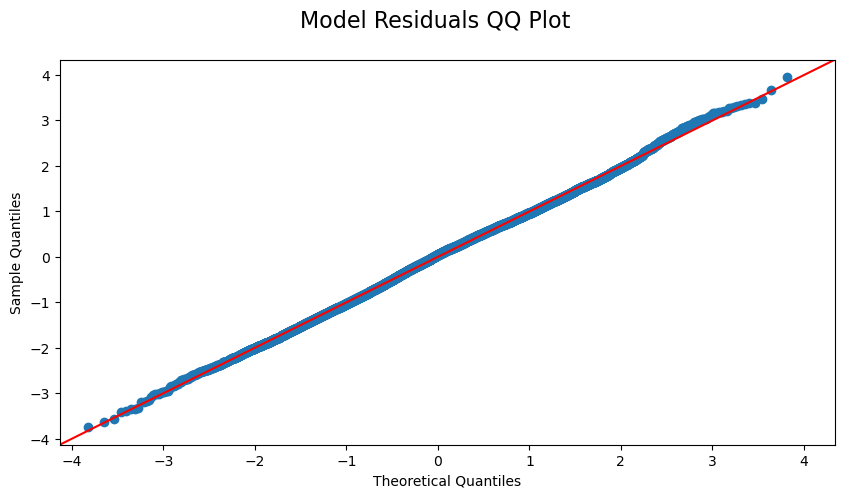

In [46]:
residuals = Model_3.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.suptitle('Model Residuals QQ Plot', fontsize=16)
fig.set_size_inches(10, 5)
fig.show()

In [47]:
y_pred_train = Model_3.predict(X)

C:\Users\zhesh\AppData\Local\Temp\ipykernel_11844\265472580.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((res), bins = 20)


Text(0.5, 0, 'Residuals')

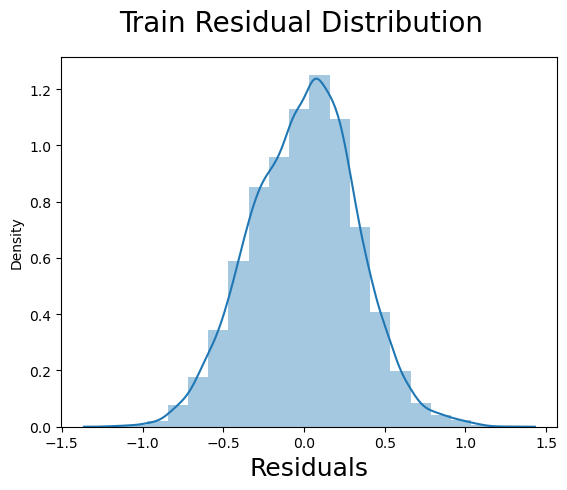

In [48]:
res = y_train-y_pred_train
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((res), bins = 20)
fig.suptitle('Train Residual Distribution', fontsize = 20)                  # Plot heading 
plt.xlabel('Residuals', fontsize = 18)   

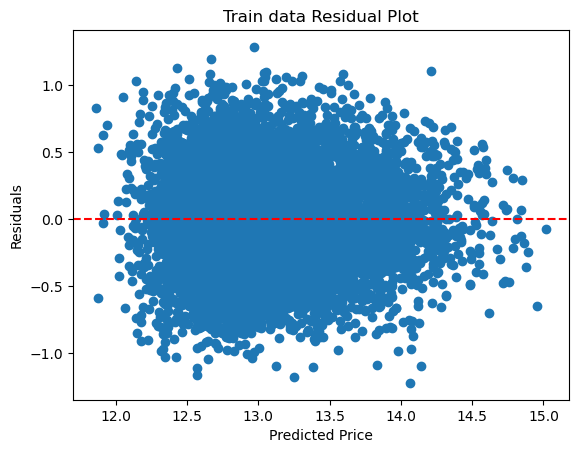

In [49]:
residuals_train = y_train - y_pred_train
plt.scatter(y_pred_train, residuals_train)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Train data Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Testing the Model

In [50]:
y_test = df_test.pop('price')
x_test = df_test



In [51]:
#using features from our third model
x_test = x_test[features_model3]

x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6408 entries, 13207 to 1953
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sqft_living    6408 non-null   float64
 1   sqft_basement  6408 non-null   float64
 2   bedrooms_3     6408 non-null   int32  
 3   bathroom1_0    6408 non-null   int32  
 4   bathroom1_75   6408 non-null   int32  
 5   bathroom2_5    6408 non-null   int32  
 6   bathroom3_25   6408 non-null   int32  
 7   bathroom3_5    6408 non-null   int32  
 8   bathroom3_75   6408 non-null   int32  
 9   bathroom4_0    6408 non-null   int32  
 10  bathroom4_25   6408 non-null   int32  
 11  floor1_5       6408 non-null   int32  
 12  floor2_5       6408 non-null   int32  
 13  floor3_0       6408 non-null   int32  
 14  grade_4        6408 non-null   int32  
 15  grade_5        6408 non-null   int32  
 16  grade_6        6408 non-null   int32  
 17  grade_8        6408 non-null   int32  
 18  grade_9  

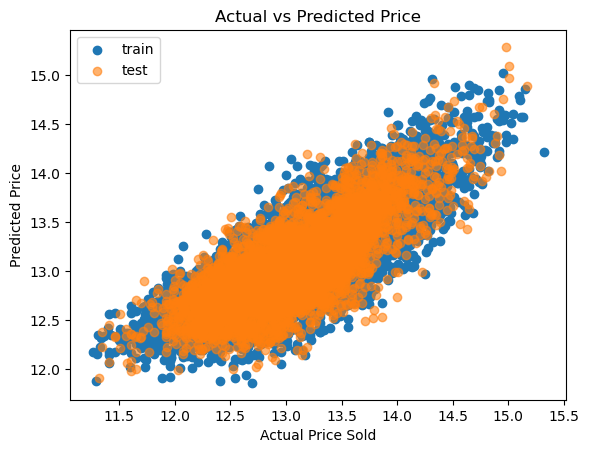

In [52]:
y_pred_test = Model_3.predict(x_test)

plt.scatter(y_train, y_pred_train, label = 'train')
plt.scatter(y_test, y_pred_test, alpha = 0.6, label = 'test')

plt.legend()
plt.xlabel('Actual Price Sold')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()

C:\Users\zhesh\AppData\Local\Temp\ipykernel_11844\3197143239.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((res), bins = 20)


Text(0.5, 0, 'Residuals')

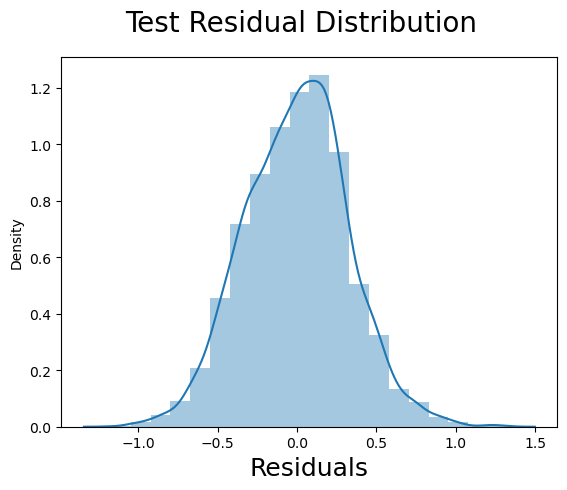

In [53]:
res = y_test-y_pred_test
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((res), bins = 20)
fig.suptitle('Test Residual Distribution', fontsize = 20)                  # Plot heading 
plt.xlabel('Residuals', fontsize = 18)   

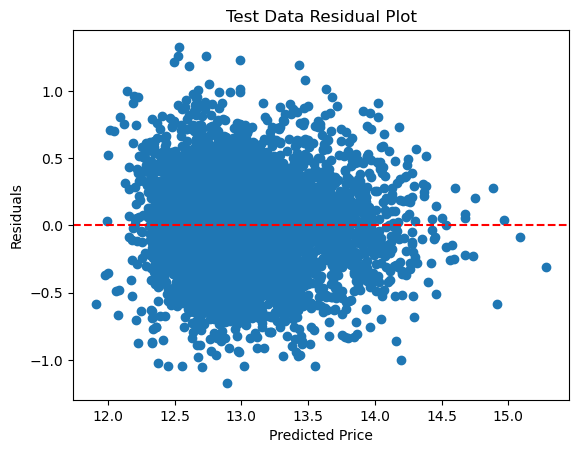

In [54]:
residuals_test = y_test - y_pred_test
plt.scatter(y_pred_test, residuals_test)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Test Data Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [55]:
from sklearn.metrics import r2_score

r2_test = r2_score(y_test, y_pred_test)
print('R-Squared for test:',r2_test)

n_test = x_test.shape[0]

# Number of features (predictors, p) is the shape along axis 1
p_test = x_test.shape[1]

# We find the Adjusted R-squared using the formula

adjusted_r2_test = 1-(1-r2_test)*(n_test-1)/(n_test-p_test-1)
print('Adjusted R-Sqaured for test:',adjusted_r2_test)

R-Squared for test: 0.5898111024076923
Adjusted R-Sqaured for test: 0.5877521150001701


In [56]:
r2_train = r2_score(y_train, y_pred_train) #We can find this on the OLS summary
print('R-Squared for train:',r2_train)

n_train = X.shape[0]

# Number of features (predictors, p) is the shape along axis 1
p_train = X.shape[1]

# We find the Adjusted R-squared using the formula

adjusted_r2_train = 1-(1-r2_train)*(n_train-1)/(n_train-p_train-1)
print('Adjusted R-Sqaured for train:',adjusted_r2_train)

R-Squared for train: 0.6033651270434894
Adjusted R-Sqaured for train: 0.6025143215779707


# Results Comparison

In [57]:
print('R-squared for train:', r2_train)
print('R-Squared for test:',r2_test)

print('Adjusted R-Sqaured for test:',adjusted_r2_train)
print('Adjusted R-sqaured for train:', adjusted_r2_test)


R-squared for train: 0.6033651270434894
R-Squared for test: 0.5898111024076923
Adjusted R-Sqaured for test: 0.6025143215779707
Adjusted R-sqaured for train: 0.5877521150001701


# Conclusion